# Burstiness Statistical Deep Dive (All Datasets)

This notebook performs a focused *deep dive* analysis on **statistical burstiness features** for
the binary classification problem.  The goal is to evaluate llm/human separability based on statistical features for the following:

- **HGLG vs MGLG**: Human-generated, Llama-graded vs Mixtral-generated, Llama-graded (Reuters-50/50 subset)
- **HGMG vs LGMG**: Human-generated, Mixtral-graded vs LLaMA-generated, Mixtral-graded (Reuters-50/50 subset)
- **HGMG vs LGMG**: Human-generated, Mixtral-graded vs LLaMA-generated, Mixtral-graded (Reuters-50/50 subset)
- **MAGE-LG**: Mixtral-graded MAGE dataset, scored by Llama
- **MAGE-MG**: Mixtral-graded MAGE dataset, scored by Mixtral
- **MAGE-LG**: Mixtral-graded MAGE dataset, scored by Llama
- **MAGE-MG**: Mixtral-graded MAGE dataset, scored by Mixtral

We concentrate on two families of features:

1. **Coefficient of √ariation (CV)** of token-level log-probabilities over rolling windows.
2. **Autocorrelation (ACF)** features summarizing temporal dependence in the log-probability series.
3. **Variation of Differences (VDF)** features summarizing token-token differences in the log-probability series.
4. **Sign Change Ratio (SCR)** features summarizing sign change in the log-probability series gradients.

For each family, we:

- Build a feature dataframe (Coefficient of Variation, Autocorrelation, Variation of First Diff).
- Perform a **threshold search** per feature (1D classifier per feature).
- Train and evaluate a **Random Forest classifier** using only that feature family.

All data loading conventions and paths follow `Burstiness-AllReuters-v2.ipynb`.


In [89]:
import os, glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from fingerprinting_llms.score import LogProbs

#   Llama-graded
HUMAN_REUTERS_LLAMA    = 'data/tokens/human_llama-graded/reuter5050/C50train_clean'
LLM_REUTERS_LLAMA_LLAMA      = 'data/tokens/llama70Bw4a16/reuter5050/C50train_clean'
LLM_REUTERS_MIXTRAL_LLAMA      = 'data/tokens/bigmixtral-llama70Bw4a16-graded/reuter5050/C50train_clean'
HUMAN_HC3_LLAMA    = 'data/tokens/hc3/human_llama-graded'
LLM_HC3_LLAMA      = 'data/tokens/hc3/chatgpt_llama-graded'
HUMAN_MAGE_LLAMA    = 'data/tokens/mage/human_llama-graded'
LLM_MAGE_LLAMA      = 'data/tokens/mage/llm_llama-graded'

#   Mixtral-graded
HUMAN_REUTERS_MIXTRAL  = 'data/tokens/human_bigmixtral-graded/reuter5050/C50train_clean'
LLM_REUTERS_MIXTRAL    = 'data/tokens/llama70Bw4a16-bigmixtral-graded/reuter5050/C50train_clean'
HUMAN_HC3_MIXTRAL    = 'data/tokens/hc3/human_mixtral-graded'
LLM_HC3_MIXTRAL      = 'data/tokens/hc3/chatgpt_mixtral-graded'
HUMAN_MAGE_MIXTRAL    = 'data/tokens/mage/human_mixtral-graded'
LLM_MAGE_MIXTRAL      = 'data/tokens/mage/llm_mixtral-graded'
LLM_REUTERS_MIXTRAL_MIXTRAL    = 'data/tokens/llama70Bw4a16-bigmixtral-graded/reuter5050/C50train_clean'

RNG = np.random.default_rng(42)


## Data Loading Helpers

In [2]:
def find_all_npz(root_dir: str) -> list[str]:
    return sorted(glob.glob(os.path.join(root_dir, '**', '*.npz'), recursive=True))

def load_logp_series_from_root(root_dir: str) -> list[np.ndarray]:
    paths = find_all_npz(root_dir)
    series = []
    for p in paths:
        if LogProbs is not None:
            lp = LogProbs.from_file(p)
            probs = np.asarray(lp.token_probs, dtype=np.float64)
        else:
            with np.load(p, allow_pickle=True) as npzfile:
                if 'token_probs' not in npzfile:
                    continue
                probs = np.asarray(npzfile['token_probs'], dtype=np.float64)

        series.append(probs)
    return series


## Rolling Window Utility

In [3]:
def rolling_windows(a: np.ndarray, window: int, step: int = 1) -> np.ndarray:
    if window < 2 or a.size < window:
        return np.empty((0, window), dtype=a.dtype)
    n = 1 + (a.size - window) // step
    shape = (n, window)
    strides = (a.strides[0]*step, a.strides[0])
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


## Coefficient of Variation (CV) Features

In [22]:
def windowed_cv_features(
    x: np.ndarray,
    window_sizes=(32,64,128),
    step_fraction=0.25
) -> dict[str, float]:
    """Compute distributional CV stats over rolling windows for each window size.

    For each window size W, we compute the coefficient of variation (CV) over
    rolling windows and then summarize the CV distribution with:
    - mean
    - 5th percentile
    - 25th percentile
    """
    feats: dict[str, float] = {}
    x = np.asarray(x, dtype=np.float64)
    from scipy.stats import skew

    for w in window_sizes:
        step = max(1, int(w * step_fraction))
        rw = rolling_windows(x, w, step=step)
        if rw.size == 0:
            feats[f'cv_local_mean_w{w}'] = np.nan
            feats[f'cv_local_p5_w{w}']  = np.nan
            feats[f'cv_local_p25_w{w}']  = np.nan
            feats[f'cv_local_p75_w{w}']  = np.nan
            continue
        mu = rw.mean(axis=1)
        sd = rw.std(axis=1, ddof=1)
        denom = np.maximum(np.abs(mu), 1e-8)
        cv = sd / denom

        # Compute distributional stats on valid CVs
        cv = cv[np.isfinite(cv)]
        if cv.size == 0:
            feats[f'cv_local_mean_w{w}'] = np.nan
            feats[f'cv_local_p5_w{w}']  = np.nan
            feats[f'cv_local_p25_w{w}']  = np.nan
            feats[f'cv_local_p75_w{w}']  = np.nan
            continue

        feats[f'cv_local_mean_w{w}'] = float(np.nanmean(cv))
        p5 = float(np.nanpercentile(cv, 5))
        p25 = float(np.nanpercentile(cv, 25))
        p75 = float(np.nanpercentile(cv, 25))
        feats[f'cv_local_p5_w{w}']  = p5
        feats[f'cv_local_p25_w{w}']  = p25
        feats[f'cv_local_p75_w{w}']  = p75

    return feats


## Autocorrelation (ACF) Features

We construct a small family of ACF-based summary features from the centered
log-probability sequence. For a maximum lag `L`, we compute the normalized
autocorrelation function `acf[k]` for lags `k = 0..L`, then derive:

- `acf_abs_sum_L{L}`: sum of |acf[k]| for k=1..L
- `acf_lag{lag}`: raw ACF value at specific lags (1, 2, 4, 8, 16, 32)


In [5]:
import numpy as np

def autocorr_1d(x: np.ndarray, max_lag: int) -> np.ndarray:
    """Compute normalized autocorrelation up to max_lag for a 1D array.

    Returns an array acf[0..max_lag] with acf[0] = 1.0.
    """
    x = np.asarray(x, dtype=np.float64)
    if x.size < 2:
        return np.ones(min(max_lag+1, x.size), dtype=np.float64)
    x = x - x.mean()
    n = x.size
    # full autocorrelation, then take non-negative lags
    corr = np.correlate(x, x, mode='full')
    mid = corr.size // 2
    corr_pos = corr[mid:mid+max_lag+1]
    # normalize by variance * n to get acf[0] = 1
    denom = corr_pos[0] if corr_pos[0] != 0 else 1.0
    acf = corr_pos / denom
    return acf

def acf_feature_dict(
    x: np.ndarray,
    max_lag: int = 64,
    summary_lags=(2,4),
) -> dict[str, float]:
    """Build a dictionary of ACF-based summary features.

    - acf_abs_sum_L{max_lag}: sum of absolute ACF values over lags 1..max_lag
    - acf_lag{lag}: ACF value at a few selected lags (if available)
    """
    feats: dict[str, float] = {}
    x = np.asarray(x, dtype=np.float64)
    if x.size < 3:
        # Too short to be informative; fallback to zeros
        feats[f'acf_abs_sum_L{max_lag}'] = 0.0
        for lag in summary_lags:
            feats[f'acf_lag{lag}'] = 0.0
        return feats

    acf = autocorr_1d(x, max_lag=max_lag)
    # sum of abs ACF over non-zero lags
    if acf.size > 1:
        feats[f'acf_abs_sum_L{max_lag}'] = float(np.sum(np.abs(acf[1:])))
    else:
        feats[f'acf_abs_sum_L{max_lag}'] = 0.0

    for lag in summary_lags:
        if lag < acf.size:
            feats[f'acf_lag{lag}'] = float(acf[lag])
        else:
            feats[f'acf_lag{lag}'] = 0.0

    return feats


##  Variation of Differences Featuers
A feature used in previous notebooks has been **Variance of First Differences** — Var(Δ\_t) with Δ\_t = x\_t − x\_{t−1}.  
This is the variance of the token-by-token fluctuations across the entire document.  Expectation is that this number will be higher for human-generated text.

We extend this notion by adding statistical measures, and increasing first diffs to include second diff (acceleration), and including absolute value

In [23]:
def var_diff_features(
    x: np.ndarray,
    n_diff=(1,2),
    absolute: bool=False,
) -> dict[str, float]:
    """
    Compute distributional stats of local variance-of-first-differences over rolling windows.
        first diffs: n==1
        second diffs: n==2 (like acceleration)
    """
    feats: dict[str, float] = {}
    x = np.asarray(x, dtype=np.float64)
    for n in n_diff:
        feats[f'vfd_local_mean_n{n}'] = np.nan
        feats[f'vfd_local_p5_n{n}']  = np.nan
        feats[f'vfd_local_p25_n{n}']  = np.nan
        feats[f'vfd_local_p75_n{n}']  = np.nan

    if x.size < 3:
        # Need at least 2 diffs to say anything local; just return NaNs.
        return feats

    for n in n_diff:
        d = np.diff(x, n=n)

        if absolute:
            d = np.abs(d)

        local_vfd = np.var(d)
        feats[f'vfd_local_mean_n{n}'] = float(np.nanmean(local_vfd))
        p5 = float(np.nanpercentile(local_vfd, 5))
        p25 = float(np.nanpercentile(local_vfd, 25))
        p75 = float(np.nanpercentile(local_vfd, 75))
        feats[f'vfd_local_p5_n{n}']  = p5
        feats[f'vfd_local_p25_n{n}']  = p25
        feats[f'vfd_local_p75_n{n}']  = p75

    return feats


## Sign Change Rate
How often does the gradient flip sign?

In [24]:
from scipy.stats import skew


def sign_change_rate_1d(x: np.ndarray) -> float:
    """Fraction of adjacent non-zero diffs whose sign flips.

    Returns:
        np.nan if fewer than 2 non-zero diffs.
    """
    x = np.asarray(x, dtype=np.float64)
    if x.size < 3:
        return np.nan

    d = np.diff(x)
    s = np.sign(d)
    # ignore zero-diffs so they don't muddy sign changes
    s = s[s != 0]
    if s.size < 2:
        return np.nan

    changes = np.sum(s[1:] * s[:-1] < 0)
    return float(changes / (s.size - 1))


def windowed_sign_change_rate_features(
    x: np.ndarray,
    window_sizes=(4, 16, 64),
    step_fraction: float = 0.25,
) -> dict[str, float]:
    """
    Compute distributional stats of local sign-change rates over rolling windows.

    For each window size W:
      - Take rolling windows of x with window length W and stride step_fraction * W
      - For each window, compute sign_change_rate_1d(window)
      - Summarize the distribution of these local rates with:
          * mean
          * std
    """
    feats: dict[str, float] = {}
    x = np.asarray(x, dtype=np.float64)

    for w in window_sizes:
        step = max(1, int(w * step_fraction))
        rw = rolling_windows(x, w, step=step)

        if rw.size == 0:
            feats[f'scr_local_mean_w{w}'] = np.nan
            feats[f'scr_local_std_w{w}']  = np.nan
            continue

        # compute sign-change rate per window (loop is fine at these sizes)
        rates = []
        for segment in rw:
            rate = sign_change_rate_1d(segment)
            if np.isfinite(rate):
                rates.append(rate)

        if not rates:
            feats[f'scr_local_mean_w{w}'] = np.nan
            feats[f'scr_local_std_w{w}']  = np.nan
            continue

        rates = np.asarray(rates, dtype=np.float64)

        feats[f'scr_local_mean_w{w}'] = float(np.nanmean(rates))
        feats[f'scr_local_std_w{w}']  = float(np.nanstd(rates, ddof=1))

    return feats


# Stats Feature Extractor 

For this deep dive, we focus on the features that do not include Fourier or Wavelet transforms.

In [25]:
def extract_stats_features_from_logp(x: np.ndarray) -> dict[str, float]:
    """Extract CV and ACF features from a 1D log-probability array."""
    x = np.asarray(x, dtype=np.float64)
    feats: dict[str, float] = {}
    # CV features over multiple window sizes
    feats.update(windowed_cv_features(x, window_sizes=(16,32,64,128), step_fraction=0.25))
    # ACF features
    feats.update(acf_feature_dict(x, max_lag=64, summary_lags=(2,4,8)))
    # Var Diff Features
    feats.update(var_diff_features(x, n_diff=(1,2), absolute=False))
    feats.update(var_diff_features(x, n_diff=(1,2), absolute=True))
    # Sign Change Features
    feats.update(windowed_sign_change_rate_features(x, window_sizes=(4,16,64), step_fraction=0.25))
    return feats

# <a color="red"><u>REUTERS</u></a>

## Llama-Generated, Mixtral-Graded

## Build Stats-Only Feature DataFrame (HGMG vs LGMG)

We now build a dataframe of features for:

- Human-generated, Mixtral-graded (HGMG) Reuters documents
- LLaMA-generated, Mixtral-graded (LGMG) Reuters documents 


In [26]:
def build_stats_feature_df(human_root: str, llm_root: str) -> pd.DataFrame:
    human_series = load_logp_series_from_root(human_root)
    llm_series   = load_logp_series_from_root(llm_root)

    rows = []
    for idx, seq in enumerate(human_series):
        feats = extract_stats_features_from_logp(seq)
        feats['label'] = 'human'
        feats['doc_id'] = f'human_{idx}'
        rows.append(feats)

    for idx, seq in enumerate(llm_series):
        feats = extract_stats_features_from_logp(seq)
        feats['label'] = 'llm'
        feats['doc_id'] = f'llm_{idx}'
        rows.append(feats)

    df = pd.DataFrame(rows)
    return df.reset_index(drop=True)

# Build the core dataframe for HGMG vs LGMG
df_stats_mixtral = build_stats_feature_df(HUMAN_REUTERS_MIXTRAL, LLM_REUTERS_MIXTRAL)
df_stats_mixtral.head()


/opt/anaconda3/envs/llm-fp/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,cv_local_mean_w16,cv_local_p5_w16,cv_local_p25_w16,cv_local_p75_w16,cv_local_mean_w32,cv_local_p5_w32,cv_local_p25_w32,cv_local_p75_w32,cv_local_mean_w64,cv_local_p5_w64,...,vfd_local_p25_n2,vfd_local_p75_n2,scr_local_mean_w4,scr_local_std_w4,scr_local_mean_w16,scr_local_std_w16,scr_local_mean_w64,scr_local_std_w64,label,doc_id
0,1.122691,0.666190,0.921553,0.921553,1.103005,0.805317,0.967950,0.967950,1.093941,0.910736,...,13.848662,13.848662,0.612500,0.338095,0.613485,0.129405,0.622984,0.047279,human,human_0
1,1.164823,0.765812,0.953847,0.953847,1.183011,0.893420,1.015508,1.015508,1.195053,0.972791,...,16.847548,16.847548,0.654630,0.320420,0.656385,0.115793,0.666667,0.038898,human,human_1
2,1.146478,0.710734,0.959291,0.959291,1.134193,0.864759,0.933232,0.933232,1.087011,1.064695,...,12.572991,12.572991,0.642857,0.309890,0.646429,0.109865,0.645161,0.045620,human,human_2
3,1.197339,0.765840,1.000160,1.000160,1.221088,0.934400,1.105129,1.105129,1.247811,1.139510,...,16.781231,16.781231,0.656463,0.314622,0.650298,0.133489,0.658358,0.049624,human,human_3
4,1.226316,0.768097,1.032446,1.032446,1.228925,0.920466,1.083167,1.083167,1.256072,1.128791,...,15.651526,15.651526,0.628571,0.322533,0.623552,0.134821,0.630323,0.063315,human,human_4


## Train / Validation Split

In [27]:
def stratified_train_val_split(df_in: pd.DataFrame, test_size: float = 0.2, seed: int = 42):
    y = (df_in['label'] == 'human').astype(int).values
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    (train_idx, val_idx) = next(splitter.split(df_in, y))
    train_df = df_in.iloc[train_idx].reset_index(drop=True)
    val_df   = df_in.iloc[val_idx].reset_index(drop=True)
    return train_df, val_df


## Per-Feature Threshold Search Utilities

For each scalar feature, we search over candidate thresholds and directions
(`>=` vs `<=`) on the **training** set to maximize macro-F₁, then evaluate that
single-threshold classifier on both train and validation splits.


In [28]:
from dataclasses import dataclass

@dataclass
class ThresholdResult:
    feature: str
    direction: str
    threshold: float
    degenerate: bool
    train_accuracy: float
    train_precision: float
    train_recall: float
    train_f1_human: float
    train_f1_llm: float
    train_f1_macro: float
    train_auroc: float
    val_accuracy: float
    val_precision: float
    val_recall: float
    val_f1_human: float
    val_f1_llm: float
    val_f1_macro: float
    val_auroc: float

def _eval_threshold(
    y_true: np.ndarray,
    scores: np.ndarray,
    threshold: float,
    direction: str,
) -> tuple[np.ndarray, dict[str,float]]:
    """Apply a single threshold to scores and compute metrics."""
    if direction == '>=':
        y_pred = (scores >= threshold).astype(int)
    else:
        y_pred = (scores <= threshold).astype(int)

    degenerate = (y_pred.min() == y_pred.max())
    metrics = {}
    metrics['degenerate'] = degenerate
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision_macro'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['recall_macro'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
    # F1s per class, then macro
    metrics['f1_human'] = f1_score(y_true, y_pred, pos_label=0, zero_division=0)
    metrics['f1_llm']   = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    metrics['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    try:
        metrics['auroc'] = roc_auc_score(y_true, scores)
    except Exception:
        metrics['auroc'] = np.nan
    return y_pred, metrics

def threshold_search_for_feature(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    feature: str,
    positive_label: str = 'llm',
    n_grid: int = 200,
    threshold_metric: str = 'accuracy',
) -> ThresholdResult:
    """Find the best 1D threshold classifier for a given feature.

    The positive class is mapped from `positive_label`. We search over
    `>=` and `<=` directions and a grid of thresholds spanning the feature
    range in the training set.
    """
    # Encode labels as 0/1
    y_train = (train_df['label'] == positive_label).astype(int).values
    y_val   = (val_df['label'] == positive_label).astype(int).values

    x_train = train_df[feature].values.astype(float)
    x_val   = val_df[feature].values.astype(float)

    finite_mask = np.isfinite(x_train)
    x_train = x_train[finite_mask]
    y_train_nonan = y_train[finite_mask]
    if x_train.size == 0:
        return ThresholdResult(
            feature, '>=', np.nan, True,
            np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
            np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
        )

    lo, hi = np.nanmin(x_train), np.nanmax(x_train)
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        lo, hi = lo, lo + 1e-6

    grid = np.linspace(lo, hi, n_grid)
    best_res = None
    best_score = -1.0

    for direction in ('>=','<='):
        for t in grid:
            _, m_train = _eval_threshold(y_train_nonan, x_train, t, direction)
            if m_train[threshold_metric] > best_score:
                best_score = m_train[threshold_metric]
                best_res = (t, direction, m_train)

    # Recompute metrics on full train and validation with best threshold
    best_t, best_dir, train_metrics = best_res
    _, train_metrics_full = _eval_threshold(y_train, train_df[feature].values.astype(float), best_t, best_dir)
    _, val_metrics = _eval_threshold(y_val, val_df[feature].values.astype(float), best_t, best_dir)

    return ThresholdResult(
        feature=feature,
        direction=best_dir,
        threshold=float(best_t),
        degenerate=train_metrics_full['degenerate'],
        train_accuracy=train_metrics_full['accuracy'],
        train_precision=train_metrics_full['precision_macro'],
        train_recall=train_metrics_full['recall_macro'],
        train_f1_human=train_metrics_full['f1_human'],
        train_f1_llm=train_metrics_full['f1_llm'],
        train_f1_macro=train_metrics_full['f1_macro'],
        train_auroc=train_metrics_full['auroc'],
        val_accuracy=val_metrics['accuracy'],
        val_precision=val_metrics['precision_macro'],
        val_recall=val_metrics['recall_macro'],
        val_f1_human=val_metrics['f1_human'],
        val_f1_llm=val_metrics['f1_llm'],
        val_f1_macro=val_metrics['f1_macro'],
        val_auroc=val_metrics['auroc'],
    )


## CV Deep Dive: Threshold Search and Random Forest

We now isolate **CV features** (`cv_local_mean_w*`) and:

1. Run a per-feature threshold search.
2. Train a Random Forest classifier using only these CV features.


In [29]:
# Split train/validation
train_stats, val_stats = stratified_train_val_split(df_stats_mixtral, test_size=0.2, seed=42)

# Identify CV feature columns (all CV-related stats)
cv_features = [c for c in df_stats_mixtral.columns if c.startswith('cv_local_')]

# Run threshold search for each CV feature
cv_results = []
for feat in cv_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    cv_results.append(res.__dict__)

cv_results_df = pd.DataFrame(cv_results).sort_values('val_f1_macro', ascending=False)
cv_results_df


,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
12,cv_local_mean_w128,<=,1.345671,False,0.821986,0.811629,0.734112,0.631424,0.882655,0.757040,NaN,0.801700,0.774726,0.715854,0.600000,0.868173,0.734087,NaN
8,cv_local_mean_w64,<=,1.344765,False,0.814184,0.807673,0.717125,0.603030,0.878704,0.740867,NaN,0.805949,0.794196,0.707437,0.586103,0.873265,0.729684,NaN
4,cv_local_mean_w32,<=,1.331409,False,0.809929,0.799080,0.713047,0.595777,0.875753,0.735765,NaN,0.798867,0.782812,0.698155,0.569697,0.868762,0.719229,NaN
0,cv_local_mean_w16,<=,1.321806,False,0.803546,0.803210,0.693830,0.561014,0.873458,0.717236,NaN,0.803116,0.807210,0.691165,0.555911,0.873521,0.714716,0.215155
14,cv_local_p25_w128,<=,1.278403,False,0.801773,0.793965,0.695809,0.564981,0.871642,0.718311,NaN,0.783286,0.765168,0.670029,0.517350,0.860274,0.688812,NaN
15,cv_local_p75_w128,<=,1.278403,False,0.801773,0.793965,0.695809,0.564981,0.871642,0.718311,NaN,0.783286,0.765168,0.670029,0.517350,0.860274,0.688812,NaN
9,cv_local_p5_w64,<=,1.118612,False,0.769504,0.740016,0.651156,0.481659,0.851801,0.666730,NaN,0.779037,0.757932,0.664175,0.506329,0.857664,0.681997,NaN
10,cv_local_p25_w64,<=,1.242743,False,0.791489,0.802523,0.665946,0.505051,0.867925,0.686488,NaN,0.767705,0.750938,0.637621,0.449664,0.852783,0.651224,NaN
11,cv_local_p75_w64,<=,1.242743,False,0.791489,0.802523,0.665946,0.505051,0.867925,0.686488,NaN,0.767705,0.750938,0.637621,0.449664,0.852783,0.651224,NaN
13,cv_local_p5_w128,<=,1.217410,False,0.786525,0.785637,0.663162,0.500829,0.864231,0.682530,NaN,0.757790,0.726721,0.627767,0.431894,0.846085,0.638989,NaN


In [30]:
# Identify ACF feature columns (all ACF-related stats)
acf_features = [c for c in df_stats_mixtral.columns if c.startswith('acf_')]

# Run threshold search for each ACF feature
acf_results = []
for feat in acf_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    acf_results.append(res.__dict__)

acf_results_df = pd.DataFrame(acf_results).sort_values('val_f1_macro', ascending=False)
acf_results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
0,acf_abs_sum_L64,<=,2.367879,False,0.789362,0.755778,0.699616,0.572662,0.860235,0.716449,0.210926,0.773371,0.726036,0.701563,0.576720,0.845261,0.710990,0.192408
1,acf_lag2,<=,0.087808,False,0.757092,0.729695,0.621586,0.416027,0.846653,0.631340,0.310934,0.739377,0.686800,0.606204,0.390728,0.834234,0.612481,0.324728
2,acf_lag4,<=,0.083824,False,0.742908,0.703528,0.597584,0.361233,0.839068,0.600151,0.347107,0.735127,0.687343,0.586078,0.334520,0.834660,0.584590,0.339350
3,acf_lag8,<=,0.088823,False,0.737589,0.727829,0.568351,0.265873,0.840242,0.553057,0.374459,0.718130,0.664843,0.535544,0.167364,0.830350,0.498857,0.361583


In [31]:
# Identify VFD feature columns (all vfd-related stats)
vfd_features = [c for c in df_stats_mixtral.columns if c.startswith('vfd_local_')]

# Run threshold search for each vfd feature
vfd_results = []
for feat in vfd_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    vfd_results.append(res.__dict__)

vfd_results_df = pd.DataFrame(vfd_results).sort_values('val_f1_macro', ascending=False)
vfd_results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
0,vfd_local_mean_n1,>=,3.985609,False,0.746099,0.737526,0.586556,0.319392,0.843941,0.581666,0.620987,0.730878,0.695425,0.564524,0.263566,0.835355,0.549461,0.612456
1,vfd_local_p5_n1,>=,3.985609,False,0.746099,0.737526,0.586556,0.319392,0.843941,0.581666,0.620987,0.730878,0.695425,0.564524,0.263566,0.835355,0.549461,0.612456
2,vfd_local_p25_n1,>=,3.985609,False,0.746099,0.737526,0.586556,0.319392,0.843941,0.581666,0.620987,0.730878,0.695425,0.564524,0.263566,0.835355,0.549461,0.612456
3,vfd_local_p75_n1,>=,3.985609,False,0.746099,0.737526,0.586556,0.319392,0.843941,0.581666,0.620987,0.730878,0.695425,0.564524,0.263566,0.835355,0.549461,0.612456
4,vfd_local_mean_n2,>=,10.626410,False,0.738652,0.724472,0.572332,0.279570,0.840373,0.559971,0.613904,0.732295,0.720576,0.558388,0.234818,0.837768,0.536293,0.603126
5,vfd_local_p5_n2,>=,10.626410,False,0.738652,0.724472,0.572332,0.279570,0.840373,0.559971,0.613904,0.732295,0.720576,0.558388,0.234818,0.837768,0.536293,0.603126
6,vfd_local_p25_n2,>=,10.626410,False,0.738652,0.724472,0.572332,0.279570,0.840373,0.559971,0.613904,0.732295,0.720576,0.558388,0.234818,0.837768,0.536293,0.603126
7,vfd_local_p75_n2,>=,10.626410,False,0.738652,0.724472,0.572332,0.279570,0.840373,0.559971,0.613904,0.732295,0.720576,0.558388,0.234818,0.837768,0.536293,0.603126


In [32]:
# Identify SCR feature columns (all scr-related stats)
scr_features = [c for c in df_stats_mixtral.columns if c.startswith('scr_local_')]

# Run threshold search for each scr feature
scr_results = []
for feat in scr_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    scr_results.append(res.__dict__)

scr_results_df = pd.DataFrame(scr_results).sort_values('val_f1_macro', ascending=False)
scr_results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
4,scr_local_mean_w64,<=,0.687308,False,0.718794,0.669126,0.533920,0.159067,0.831169,0.495118,NaN,0.718130,0.671497,0.532689,0.153191,0.830926,0.492059,NaN
2,scr_local_mean_w16,<=,0.682600,False,0.717730,0.653174,0.538553,0.184426,0.829331,0.506879,NaN,0.703966,0.592287,0.525544,0.160643,0.820292,0.490467,0.428883
0,scr_local_mean_w4,<=,0.687404,False,0.715603,0.662946,0.524132,0.118681,0.830444,0.474563,NaN,0.713881,0.654373,0.522553,0.114035,0.829392,0.471713,0.442379
1,scr_local_std_w4,>=,0.300908,False,0.715603,0.670784,0.521979,0.106904,0.830873,0.468889,NaN,0.709632,0.623396,0.512417,0.072398,0.827876,0.450137,0.505510
5,scr_local_std_w64,>=,0.023216,False,0.719858,0.789073,0.521033,0.085648,0.834590,0.460119,NaN,0.711048,0.648295,0.511990,0.064220,0.829146,0.446683,NaN
3,scr_local_std_w16,>=,0.082710,False,0.715957,0.834313,0.512539,0.049822,0.833021,0.441421,NaN,0.708215,0.605301,0.505709,0.037383,0.828047,0.432715,0.518320


Mixtral-graded (HGMG vs LGMG) : CV-only Random Forest
accuracy (val):        0.809
precision_macro (val): 0.781
recall_macro (val):    0.731
f1_macro (val):        0.748
AUROC (val):           0.829


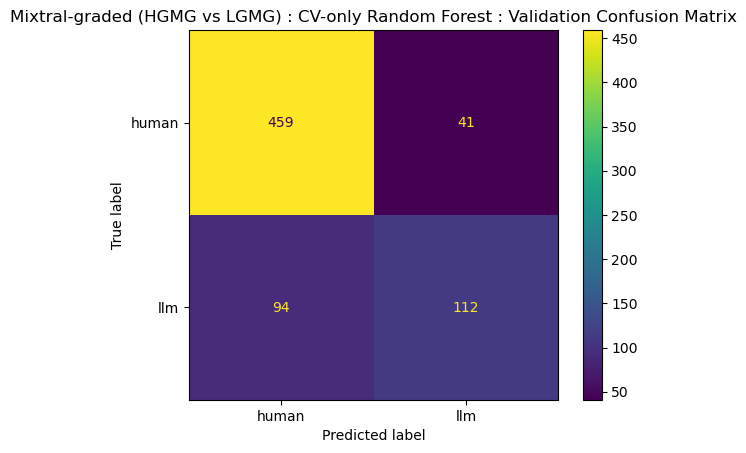

cv_local_mean_w64     0.134414
cv_local_mean_w128    0.131217
cv_local_mean_w32     0.105197
cv_local_mean_w16     0.086198
cv_local_p75_w128     0.059649
cv_local_p25_w128     0.052775
cv_local_p75_w64      0.050220
cv_local_p25_w64      0.050213
cv_local_p5_w128      0.049297
cv_local_p5_w32       0.044252
cv_local_p5_w16       0.041645
cv_local_p25_w16      0.041409
cv_local_p5_w64       0.041326
cv_local_p75_w16      0.038667
cv_local_p25_w32      0.037385
cv_local_p75_w32      0.036134
dtype: float64

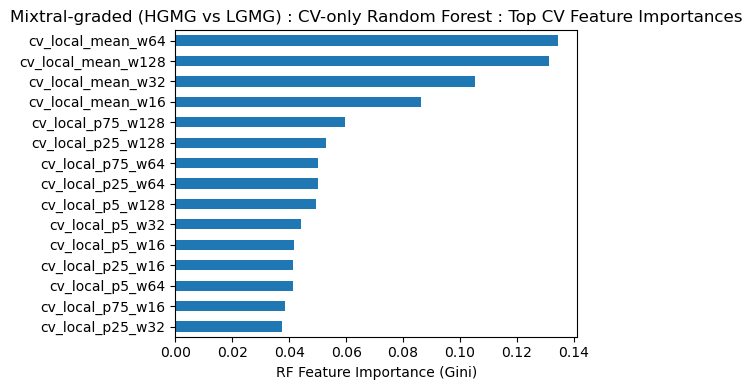

In [33]:
def model_eval_random_forest_subset(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    feature_cols: list[str],
    title: str = "",
):
    # Prepare design matrices
    X_train = train_df[feature_cols].copy().fillna(train_df[feature_cols].mean())
    X_val   = val_df[feature_cols].copy().fillna(train_df[feature_cols].mean())

    le = LabelEncoder()
    le.fit(train_df['label'])
    y_train = le.transform(train_df['label'])
    y_val   = le.transform(val_df['label'])

    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1,
    )
    rf.fit(X_train, y_train)

    y_val_pred = rf.predict(X_val)
    y_val_proba = rf.predict_proba(X_val)[:, 1]

    acc  = accuracy_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred, average='macro', zero_division=0)
    rec  = recall_score(y_val, y_val_pred, average='macro', zero_division=0)
    f1m  = f1_score(y_val, y_val_pred, average='macro', zero_division=0)
    auroc = roc_auc_score(y_val, y_val_proba)

    print(f"{title}")
    print("="*len(title))
    print(f"accuracy (val):        {acc:.3f}")
    print(f"precision_macro (val): {prec:.3f}")
    print(f"recall_macro (val):    {rec:.3f}")
    print(f"f1_macro (val):        {f1m:.3f}")
    print(f"AUROC (val):           {auroc:.3f}")

    cm = confusion_matrix(y_val, y_val_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.inverse_transform([0,1]))
    disp.plot(values_format='d')
    plt.title(f'{title} : Validation Confusion Matrix')
    plt.show()

    importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
    display(importances.head(20))
    plt.figure(figsize=(6,4))
    importances.head(15).plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.xlabel('RF Feature Importance (Gini)')
    plt.title(f'{title} : Top CV Feature Importances')
    plt.tight_layout()
    plt.show()

    return {
        'model': rf,
        'feature_cols': feature_cols,
        'label_encoder': le,
        'val_predictions': y_val_pred,
        'val_truth': y_val,
        'val_proba': y_val_proba,
        'val_feature_importances': importances,
    }

# Run RF on CV features only
cv_rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=cv_features,
    title='Mixtral-graded (HGMG vs LGMG) : CV-only Random Forest'
)


## All Features

Now we repeat the same procedure using **All features**.


Mixtral-graded (HGMG vs LGMG) : All Features Random Forest
accuracy (val):        0.840
precision_macro (val): 0.821
recall_macro (val):    0.776
f1_macro (val):        0.793
AUROC (val):           0.888


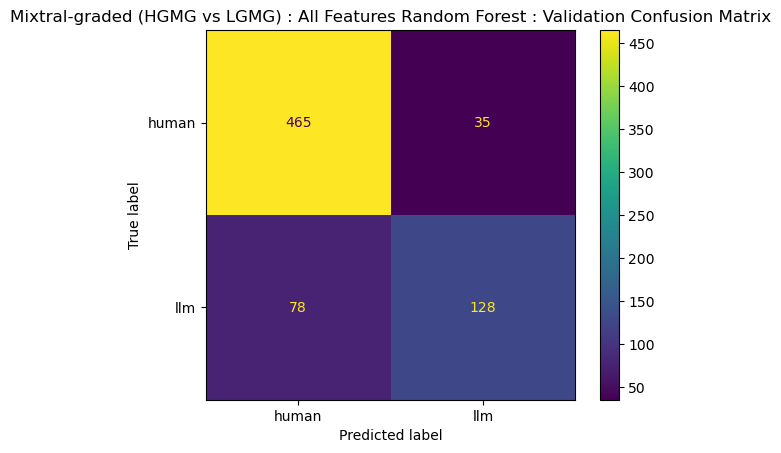

acf_abs_sum_L64       0.097738
cv_local_mean_w128    0.075367
cv_local_mean_w64     0.073889
cv_local_mean_w32     0.066668
cv_local_mean_w16     0.055251
cv_local_p25_w128     0.036408
cv_local_p75_w128     0.035213
acf_lag4              0.030712
cv_local_p75_w64      0.030679
cv_local_p25_w64      0.029774
acf_lag2              0.028961
cv_local_p5_w128      0.026102
scr_local_std_w4      0.024401
cv_local_p25_w16      0.022586
cv_local_p25_w32      0.021801
cv_local_p75_w16      0.021497
scr_local_mean_w16    0.021368
scr_local_mean_w64    0.020699
acf_lag8              0.020411
vfd_local_mean_n1     0.019877
dtype: float64

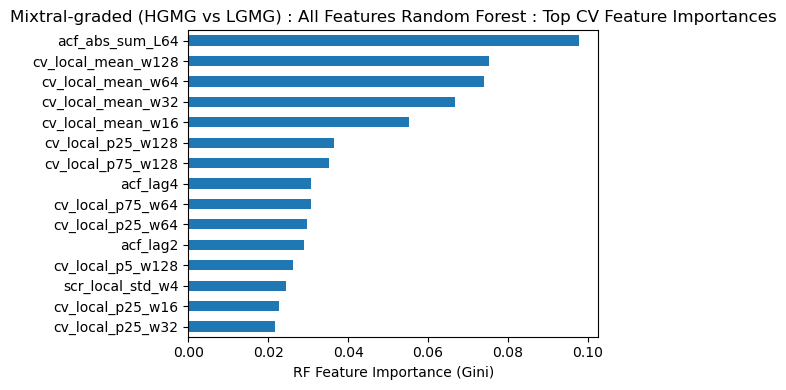

In [36]:
# Run RF on ACF features only
all_features = cv_features + acf_features + vfd_features + scr_features
cv_rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=all_features,
    title='Mixtral-graded (HGMG vs LGMG) : All Features Random Forest'
)

## RESULTS (Reuters Llama-Generated, Mixtral-Graded)
0.8 seems to be the ceiling for our classification accuracy (F1 score) using these features on Reuters Llama-Generated, Mixtral-Graded.

# <a color="red"><u>REUTERS</u></a>

## Mixtral-Generated, Llama-Graded

# <a color="red"><u>REUTERS</u></a>

## Mixtral-Generated, Llama-Graded

## Build Stats-Only Feature DataFrame (HGMG vs LGMG)

We now build a dataframe of features for:

- Human-generated, Llama-graded (HGLG) Reuters documents
- Mixtral-generated, Llama-graded (MGLG) Reuters documents 


In [90]:
# Build the core dataframe for HGMG vs LGMG
df_stats_llama = build_stats_feature_df(HUMAN_REUTERS_LLAMA, LLM_REUTERS_MIXTRAL_LLAMA)
df_stats_llama.head()


/opt/anaconda3/envs/llm-fp/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,cv_local_mean_w16,cv_local_p5_w16,cv_local_p25_w16,cv_local_p75_w16,cv_local_mean_w32,cv_local_p5_w32,cv_local_p25_w32,cv_local_p75_w32,cv_local_mean_w64,cv_local_p5_w64,...,vfd_local_p25_n2,vfd_local_p75_n2,scr_local_mean_w4,scr_local_std_w4,scr_local_mean_w16,scr_local_std_w16,scr_local_mean_w64,scr_local_std_w64,label,doc_id
0,1.089856,0.745813,0.922502,0.922502,1.076676,0.787505,0.977653,0.977653,1.084879,0.937672,...,15.119125,15.119125,0.632391,0.338401,0.629323,0.104862,0.629032,0.040161,human,human_0
1,1.080927,0.796076,0.919697,0.919697,1.111032,0.902078,1.005448,1.005448,1.117150,0.933258,...,18.424002,18.424002,0.660000,0.317177,0.658080,0.100273,0.657258,0.028322,human,human_1
2,1.030738,0.697162,0.807762,0.807762,1.032324,0.806727,0.837528,0.837528,1.014691,0.999195,...,13.407359,13.407359,0.620482,0.298271,0.615079,0.081768,0.604839,0.034215,human,human_2
3,1.160115,0.740535,0.973550,0.973550,1.174636,0.833311,1.065589,1.065589,1.190271,0.976207,...,17.318093,17.318093,0.650183,0.318209,0.649787,0.106152,0.648283,0.045509,human,human_3
4,1.198521,0.764081,0.993834,0.993834,1.189164,0.854885,1.066820,1.066820,1.193207,0.956481,...,15.898697,15.898697,0.645047,0.314465,0.642164,0.113378,0.639551,0.055150,human,human_4


## Train / Validation Split

## Per-Feature Threshold Search Utilities

For each scalar feature, we search over candidate thresholds and directions
(`>=` vs `<=`) on the **training** set to maximize macro-F₁, then evaluate that
single-threshold classifier on both train and validation splits.


## CV Deep Dive: Threshold Search and Random Forest

We now isolate **CV features** (`cv_local_mean_w*`) and:

1. Run a per-feature threshold search.
2. Train a Random Forest classifier using only these CV features.


In [91]:
# Split train/validation
train_stats, val_stats = stratified_train_val_split(df_stats_llama, test_size=0.2, seed=42)

# Identify CV feature columns (all CV-related stats)
cv_features = [c for c in df_stats_llama.columns if c.startswith('cv_local_')]

# Run threshold search for each CV feature
cv_results = []
for feat in cv_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    cv_results.append(res.__dict__)

cv_results_df = pd.DataFrame(cv_results).sort_values('val_f1_macro', ascending=False)
cv_results_df


,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
12,cv_local_mean_w128,<=,1.243880,False,0.783280,0.751878,0.690276,0.557833,0.856464,0.707148,NaN,0.767575,0.725789,0.671748,0.526316,0.846008,0.686162,NaN
8,cv_local_mean_w64,<=,1.242403,False,0.778256,0.750391,0.675038,0.529680,0.854930,0.692305,NaN,0.758967,0.717870,0.648577,0.481481,0.842991,0.662236,NaN
14,cv_local_p25_w128,<=,1.185069,False,0.762827,0.728801,0.649236,0.480754,0.846315,0.663534,NaN,0.736011,0.677069,0.622358,0.435583,0.827715,0.631649,NaN
15,cv_local_p75_w128,<=,1.185069,False,0.762827,0.728801,0.649236,0.480754,0.846315,0.663534,NaN,0.736011,0.677069,0.622358,0.435583,0.827715,0.631649,NaN
4,cv_local_mean_w32,<=,1.252905,False,0.763904,0.750118,0.633370,0.440476,0.850387,0.645431,NaN,0.748924,0.716915,0.613008,0.398625,0.841342,0.619984,NaN
10,cv_local_p25_w64,<=,1.158305,False,0.761033,0.749751,0.626027,0.422877,0.849321,0.636099,NaN,0.741750,0.699708,0.605081,0.383562,0.836661,0.610111,NaN
11,cv_local_p75_w64,<=,1.158305,False,0.761033,0.749751,0.626027,0.422877,0.849321,0.636099,NaN,0.741750,0.699708,0.605081,0.383562,0.836661,0.610111,NaN
13,cv_local_p5_w128,<=,1.142000,False,0.759957,0.739989,0.629509,0.433531,0.847712,0.640622,NaN,0.737446,0.688376,0.602033,0.379661,0.833485,0.606573,NaN
6,cv_local_p25_w32,<=,1.104811,False,0.742375,0.715028,0.595812,0.353153,0.839158,0.596155,NaN,0.723099,0.658651,0.577642,0.322807,0.825969,0.574388,NaN
7,cv_local_p75_w32,<=,1.104811,False,0.742375,0.715028,0.595812,0.353153,0.839158,0.596155,NaN,0.723099,0.658651,0.577642,0.322807,0.825969,0.574388,NaN


In [92]:
# Identify ACF feature columns (all ACF-related stats)
acf_features = [c for c in df_stats_llama.columns if c.startswith('acf_')]

# Run threshold search for each ACF feature
acf_results = []
for feat in acf_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    acf_results.append(res.__dict__)

acf_results_df = pd.DataFrame(acf_results).sort_values('val_f1_macro', ascending=False)
acf_results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
0,acf_abs_sum_L64,<=,2.671690,False,0.745246,0.718465,0.602093,0.369449,0.840378,0.604914,0.307236,0.737446,0.698321,0.590650,0.344086,0.835874,0.589980,0.328188
1,acf_lag2,<=,0.101814,False,0.741299,0.719225,0.590095,0.335484,0.839385,0.587435,0.309258,0.730273,0.682613,0.578455,0.313869,0.832143,0.573006,0.290631
3,acf_lag8,<=,0.084859,False,0.730893,0.704317,0.567855,0.271845,0.834947,0.553396,0.363390,0.721664,0.677868,0.549593,0.217742,0.830716,0.524229,0.393109
2,acf_lag4,<=,0.091659,False,0.726229,0.687729,0.562071,0.258503,0.832123,0.545313,0.383586,0.713056,0.638903,0.542073,0.206349,0.824869,0.515609,0.364198


In [93]:
# Identify VFD feature columns (all vfd-related stats)
vfd_features = [c for c in df_stats_llama.columns if c.startswith('vfd_local_')]

# Run threshold search for each vfd feature
vfd_results = []
for feat in vfd_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    vfd_results.append(res.__dict__)

vfd_results_df = pd.DataFrame(vfd_results).sort_values('val_f1_macro', ascending=False)
vfd_results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
0,vfd_local_mean_n1,<=,6.526436,False,0.755292,0.735032,0.619832,0.411054,0.845562,0.628308,NaN,0.758967,0.739109,0.625813,0.424658,0.847550,0.636104,0.388211
1,vfd_local_p5_n1,<=,6.526436,False,0.755292,0.735032,0.619832,0.411054,0.845562,0.628308,NaN,0.758967,0.739109,0.625813,0.424658,0.847550,0.636104,0.388211
2,vfd_local_p25_n1,<=,6.526436,False,0.755292,0.735032,0.619832,0.411054,0.845562,0.628308,NaN,0.758967,0.739109,0.625813,0.424658,0.847550,0.636104,0.388211
3,vfd_local_p75_n1,<=,6.526436,False,0.755292,0.735032,0.619832,0.411054,0.845562,0.628308,NaN,0.758967,0.739109,0.625813,0.424658,0.847550,0.636104,0.388211
4,vfd_local_mean_n2,>=,11.529720,False,0.728023,0.709421,0.557682,0.235887,0.834570,0.535229,NaN,0.731707,0.747360,0.555285,0.217573,0.838095,0.527834,0.565824
5,vfd_local_p5_n2,>=,11.529720,False,0.728023,0.709421,0.557682,0.235887,0.834570,0.535229,NaN,0.731707,0.747360,0.555285,0.217573,0.838095,0.527834,0.565824
6,vfd_local_p25_n2,>=,11.529720,False,0.728023,0.709421,0.557682,0.235887,0.834570,0.535229,NaN,0.731707,0.747360,0.555285,0.217573,0.838095,0.527834,0.565824
7,vfd_local_p75_n2,>=,11.529720,False,0.728023,0.709421,0.557682,0.235887,0.834570,0.535229,NaN,0.731707,0.747360,0.555285,0.217573,0.838095,0.527834,0.565824


In [94]:
# Identify SCR feature columns (all scr-related stats)
scr_features = [c for c in df_stats_llama.columns if c.startswith('scr_local_')]

# Run threshold search for each scr feature
scr_results = []
for feat in scr_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    scr_results.append(res.__dict__)

scr_results_df = pd.DataFrame(scr_results).sort_values('val_f1_macro', ascending=False)
scr_results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
5,scr_local_std_w64,>=,0.011721,False,0.719053,0.799181,0.525846,0.103093,0.833440,0.468266,NaN,0.718795,0.812417,0.523374,0.092593,0.833616,0.463104,NaN
4,scr_local_mean_w64,>=,0.549851,False,0.714388,0.838069,0.516169,0.063529,0.831499,0.447514,NaN,0.714491,0.856006,0.514634,0.056872,0.831784,0.444328,NaN
3,scr_local_std_w16,>=,0.080534,False,0.712594,0.786546,0.514189,0.058754,0.830404,0.444579,NaN,0.713056,0.855491,0.512195,0.047619,0.831081,0.439350,0.535653
1,scr_local_std_w4,>=,0.273356,False,0.709006,0.853927,0.506691,0.026411,0.828939,0.427675,NaN,0.707317,0.853448,0.502439,0.009709,0.828283,0.418996,0.495127
2,scr_local_mean_w16,>=,0.572745,False,0.709006,0.853927,0.506691,0.026411,0.828939,0.427675,NaN,0.707317,0.853448,0.502439,0.009709,0.828283,0.418996,0.455741
0,scr_local_mean_w4,>=,0.579423,False,0.708647,0.853799,0.506083,0.024038,0.828764,0.426401,NaN,0.705882,0.352941,0.500000,0.000000,0.827586,0.413793,0.460257


Mixtral-Generated, Llama-Graded (HGLG vs MGLG) : CV-only Random Forest
accuracy (val):        0.802
precision_macro (val): 0.779
recall_macro (val):    0.715
f1_macro (val):        0.734
AUROC (val):           0.808


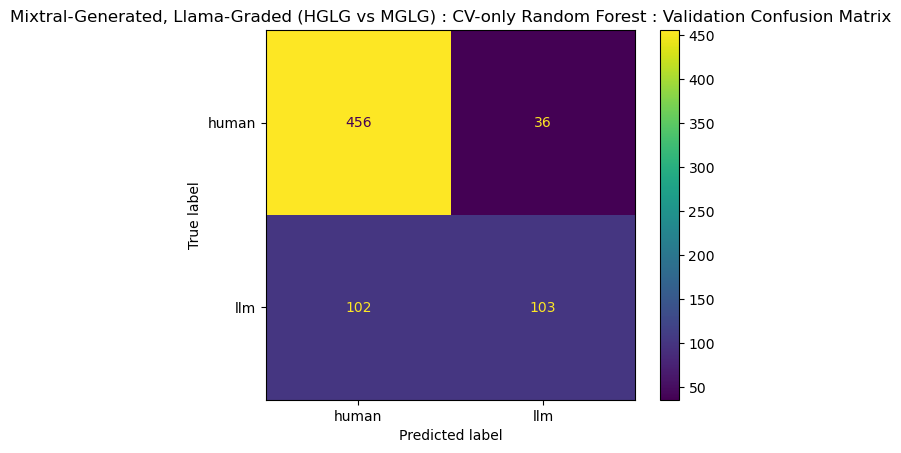

cv_local_mean_w128    0.172564
cv_local_mean_w64     0.116185
cv_local_mean_w16     0.083215
cv_local_mean_w32     0.080461
cv_local_p75_w128     0.053815
cv_local_p5_w128      0.053388
cv_local_p25_w64      0.053200
cv_local_p5_w64       0.049639
cv_local_p75_w64      0.048533
cv_local_p25_w128     0.048227
cv_local_p5_w32       0.041981
cv_local_p5_w16       0.040674
cv_local_p75_w16      0.040499
cv_local_p25_w16      0.039616
cv_local_p25_w32      0.039405
cv_local_p75_w32      0.038598
dtype: float64

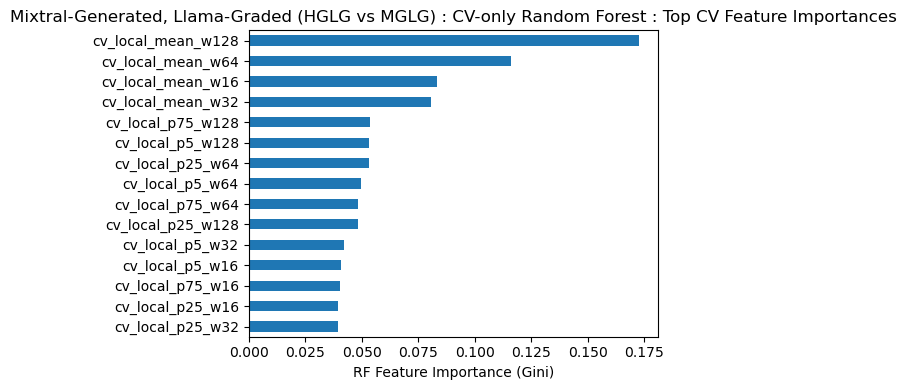

In [95]:
# Run RF on CV features only
cv_rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=cv_features,
    title='Mixtral-Generated, Llama-Graded (HGLG vs MGLG) : CV-only Random Forest'
)


## All Features

Now we repeat the same procedure using **All features**.


Mixtral-Generated, Llama-Graded (HGLG vs MGLG) : All Features Random Forest
accuracy (val):        0.900
precision_macro (val): 0.906
recall_macro (val):    0.848
f1_macro (val):        0.870
AUROC (val):           0.929


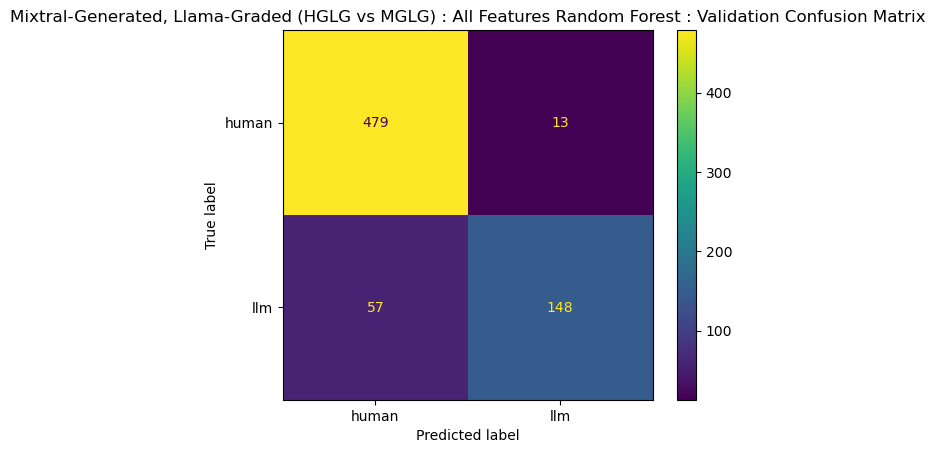

cv_local_mean_w128    0.071541
vfd_local_p75_n1      0.064554
vfd_local_p25_n1      0.064183
vfd_local_p5_n1       0.063104
vfd_local_mean_n1     0.061371
cv_local_mean_w64     0.054489
acf_abs_sum_L64       0.047669
vfd_local_p25_n2      0.040503
vfd_local_p5_n2       0.040161
vfd_local_mean_n2     0.040010
vfd_local_p75_n2      0.039143
cv_local_mean_w32     0.035813
acf_lag2              0.032060
cv_local_p25_w64      0.024683
cv_local_mean_w16     0.023649
acf_lag4              0.023251
cv_local_p25_w128     0.022966
cv_local_p75_w128     0.022951
cv_local_p5_w128      0.021198
cv_local_p75_w64      0.020032
dtype: float64

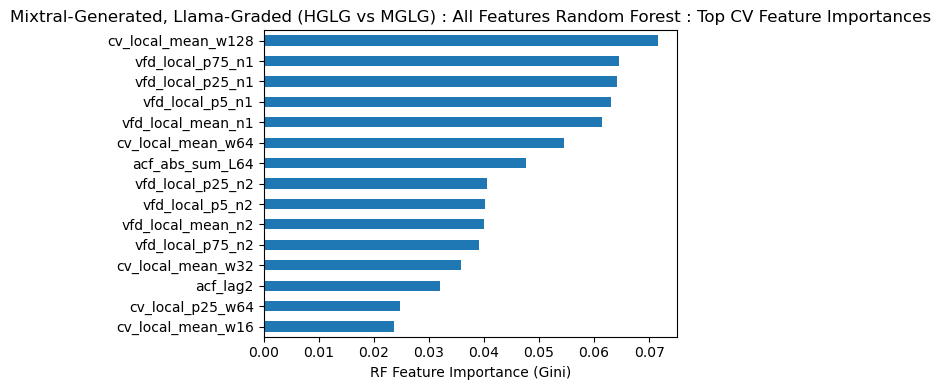

In [96]:
# Run RF on ACF features only
all_features = cv_features + acf_features + vfd_features + scr_features
cv_rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=all_features,
    title='Mixtral-Generated, Llama-Graded (HGLG vs MGLG) : All Features Random Forest'
)

## RESULTS (Reuters Mixtral-Generated, Llama-Graded)
0.87 F1 score for Mixtral-Generated, Llama-Graded.  Decent separation.

# Llama-Generated, Llama-Graded (SAME MODEL) Reuters

## Build Stats-Only Feature DataFrame (HGLG vs LGLG)

We now build a dataframe of features for:

- Human-generated, Llama-graded (HGLG) Reuters documents
- Mixtral-generated, Llama-graded (LGLG) Reuters documents 


In [82]:
# Build the core dataframe for HGMG vs LGMG
df_stats_llama = build_stats_feature_df(HUMAN_REUTERS_LLAMA, LLM_REUTERS_LLAMA_LLAMA)
df_stats_llama.head()


/opt/anaconda3/envs/llm-fp/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,cv_local_mean_w16,cv_local_p5_w16,cv_local_p25_w16,cv_local_p75_w16,cv_local_mean_w32,cv_local_p5_w32,cv_local_p25_w32,cv_local_p75_w32,cv_local_mean_w64,cv_local_p5_w64,...,vfd_local_p25_n2,vfd_local_p75_n2,scr_local_mean_w4,scr_local_std_w4,scr_local_mean_w16,scr_local_std_w16,scr_local_mean_w64,scr_local_std_w64,label,doc_id
0,1.089856,0.745813,0.922502,0.922502,1.076676,0.787505,0.977653,0.977653,1.084879,0.937672,...,15.119125,15.119125,0.632391,0.338401,0.629323,0.104862,0.629032,0.040161,human,human_0
1,1.080927,0.796076,0.919697,0.919697,1.111032,0.902078,1.005448,1.005448,1.117150,0.933258,...,18.424002,18.424002,0.660000,0.317177,0.658080,0.100273,0.657258,0.028322,human,human_1
2,1.030738,0.697162,0.807762,0.807762,1.032324,0.806727,0.837528,0.837528,1.014691,0.999195,...,13.407359,13.407359,0.620482,0.298271,0.615079,0.081768,0.604839,0.034215,human,human_2
3,1.160115,0.740535,0.973550,0.973550,1.174636,0.833311,1.065589,1.065589,1.190271,0.976207,...,17.318093,17.318093,0.650183,0.318209,0.649787,0.106152,0.648283,0.045509,human,human_3
4,1.198521,0.764081,0.993834,0.993834,1.189164,0.854885,1.066820,1.066820,1.193207,0.956481,...,15.898697,15.898697,0.645047,0.314465,0.642164,0.113378,0.639551,0.055150,human,human_4


## Train / Validation Split

## Per-Feature Threshold Search Utilities

For each scalar feature, we search over candidate thresholds and directions
(`>=` vs `<=`) on the **training** set to maximize macro-F₁, then evaluate that
single-threshold classifier on both train and validation splits.


## CV Deep Dive: Threshold Search and Random Forest

We now isolate **CV features** (`cv_local_mean_w*`) and:

1. Run a per-feature threshold search.
2. Train a Random Forest classifier using only these CV features.


In [83]:
# Split train/validation
train_stats, val_stats = stratified_train_val_split(df_stats_llama, test_size=0.2, seed=42)

# Identify CV feature columns (all CV-related stats)
cv_features = [c for c in df_stats_llama.columns if c.startswith('cv_local_')]

# Run threshold search for each CV feature
cv_results = []
for feat in cv_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    cv_results.append(res.__dict__)

cv_results_df = pd.DataFrame(cv_results).sort_values('val_f1_macro', ascending=False)
cv_results_df


,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
12,cv_local_mean_w128,<=,1.287096,False,0.926404,0.928076,0.919496,0.907512,0.938888,0.923200,NaN,0.932773,0.934314,0.926439,0.915663,0.944112,0.929887,NaN
14,cv_local_p25_w128,<=,1.215503,False,0.916191,0.918784,0.907706,0.893795,0.930786,0.912291,NaN,0.919568,0.922873,0.910760,0.897710,0.933729,0.915719,NaN
15,cv_local_p75_w128,<=,1.215503,False,0.916191,0.918784,0.907706,0.893795,0.930786,0.912291,NaN,0.919568,0.922873,0.910760,0.897710,0.933729,0.915719,NaN
8,cv_local_mean_w64,<=,1.278559,False,0.919195,0.924818,0.908793,0.896179,0.933858,0.915018,NaN,0.918367,0.924528,0.907494,0.894737,0.933333,0.914035,0.026840
13,cv_local_p5_w128,<=,1.146018,False,0.911685,0.912737,0.904113,0.888889,0.926720,0.907804,NaN,0.912365,0.914090,0.904212,0.889226,0.927507,0.908367,NaN
4,cv_local_mean_w32,<=,1.241764,False,0.887954,0.889181,0.878181,0.857688,0.907605,0.882646,0.053368,0.887155,0.890906,0.875221,0.854489,0.907843,0.881166,0.049120
10,cv_local_p25_w64,<=,1.146600,False,0.890057,0.891353,0.880411,0.860412,0.909316,0.884864,NaN,0.885954,0.888158,0.875104,0.854071,0.906404,0.880237,0.050551
11,cv_local_p75_w64,<=,1.146600,False,0.890057,0.891353,0.880411,0.860412,0.909316,0.884864,NaN,0.885954,0.888158,0.875104,0.854071,0.906404,0.880237,0.050551
9,cv_local_p5_w64,<=,1.031041,False,0.842295,0.839115,0.832890,0.802260,0.868848,0.835554,NaN,0.835534,0.830181,0.829271,0.798233,0.861196,0.829714,0.092417
0,cv_local_mean_w16,<=,1.199264,False,0.829679,0.826430,0.818951,0.785146,0.858920,0.822033,0.101162,0.836735,0.834513,0.825337,0.792683,0.865347,0.829015,0.095469


In [84]:
# Identify ACF feature columns (all ACF-related stats)
acf_features = [c for c in df_stats_llama.columns if c.startswith('acf_')]

# Run threshold search for each ACF feature
acf_results = []
for feat in acf_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    acf_results.append(res.__dict__)

acf_results_df = pd.DataFrame(acf_results).sort_values('val_f1_macro', ascending=False)
acf_results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
0,acf_abs_sum_L64,<=,2.437457,False,0.886152,0.881667,0.883718,0.862332,0.902945,0.882638,0.054104,0.866747,0.862121,0.862444,0.837482,0.887080,0.862281,0.059390
1,acf_lag2,<=,0.081996,False,0.816161,0.819141,0.797635,0.755981,0.852530,0.804255,0.132524,0.787515,0.792366,0.763870,0.709360,0.832545,0.770952,0.164592
2,acf_lag4,<=,0.057531,False,0.801742,0.798354,0.787775,0.745958,0.837438,0.791698,0.144451,0.768307,0.762064,0.753910,0.704441,0.809477,0.756959,0.182605
3,acf_lag8,<=,0.053716,False,0.737759,0.737480,0.710593,0.636401,0.794926,0.715664,0.226957,0.734694,0.733622,0.707454,0.632280,0.792488,0.712384,0.244993


In [85]:
# Identify VFD feature columns (all vfd-related stats)
vfd_features = [c for c in df_stats_llama.columns if c.startswith('vfd_local_')]

# Run threshold search for each vfd feature
vfd_results = []
for feat in vfd_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    vfd_results.append(res.__dict__)

vfd_results_df = pd.DataFrame(vfd_results).sort_values('val_f1_macro', ascending=False)
vfd_results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
0,vfd_local_mean_n1,>=,4.333163,False,0.826975,0.850887,0.798835,0.752790,0.866913,0.809851,0.871599,0.835534,0.863445,0.806770,0.763385,0.873965,0.818675,0.877500
1,vfd_local_p5_n1,>=,4.333163,False,0.826975,0.850887,0.798835,0.752790,0.866913,0.809851,0.871599,0.835534,0.863445,0.806770,0.763385,0.873965,0.818675,0.877500
2,vfd_local_p25_n1,>=,4.333163,False,0.826975,0.850887,0.798835,0.752790,0.866913,0.809851,0.871599,0.835534,0.863445,0.806770,0.763385,0.873965,0.818675,0.877500
3,vfd_local_p75_n1,>=,4.333163,False,0.826975,0.850887,0.798835,0.752790,0.866913,0.809851,0.871599,0.835534,0.863445,0.806770,0.763385,0.873965,0.818675,0.877500
4,vfd_local_mean_n2,>=,12.178608,False,0.812556,0.828456,0.786060,0.736486,0.854545,0.795516,0.852606,0.827131,0.843656,0.801907,0.758389,0.865421,0.811905,0.857473
5,vfd_local_p5_n2,>=,12.178608,False,0.812556,0.828456,0.786060,0.736486,0.854545,0.795516,0.852606,0.827131,0.843656,0.801907,0.758389,0.865421,0.811905,0.857473
6,vfd_local_p25_n2,>=,12.178608,False,0.812556,0.828456,0.786060,0.736486,0.854545,0.795516,0.852606,0.827131,0.843656,0.801907,0.758389,0.865421,0.811905,0.857473
7,vfd_local_p75_n2,>=,12.178608,False,0.812556,0.828456,0.786060,0.736486,0.854545,0.795516,0.852606,0.827131,0.843656,0.801907,0.758389,0.865421,0.811905,0.857473


In [86]:
# Identify SCR feature columns (all scr-related stats)
scr_features = [c for c in df_stats_llama.columns if c.startswith('scr_local_')]

# Run threshold search for each scr feature
scr_results = []
for feat in scr_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    scr_results.append(res.__dict__)

scr_results_df = pd.DataFrame(scr_results).sort_values('val_f1_macro', ascending=False)
scr_results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
5,scr_local_std_w64,>=,0.039958,False,0.627516,0.620369,0.570232,0.357513,0.737733,0.547623,NaN,0.630252,0.620595,0.576288,0.381526,0.736301,0.558914,NaN
3,scr_local_std_w16,>=,0.100125,False,0.619105,0.621955,0.551223,0.273769,0.741857,0.507813,0.546947,0.613445,0.606714,0.545410,0.264840,0.737785,0.501313,0.545967
1,scr_local_std_w4,>=,0.304924,False,0.600481,0.575117,0.533541,0.250282,0.727682,0.488982,0.521391,0.602641,0.578665,0.536714,0.262806,0.728020,0.495413,0.516755
2,scr_local_mean_w16,>=,0.618196,False,0.596876,0.596690,0.513222,0.092016,0.740927,0.416471,0.498948,0.600240,0.616169,0.516680,0.102426,0.742857,0.422642,0.494302
0,scr_local_mean_w4,>=,0.619484,False,0.595975,0.586377,0.512907,0.096709,0.739795,0.418252,0.503618,0.601441,0.632961,0.517247,0.097826,0.744222,0.421024,0.494227
4,scr_local_mean_w64,>=,0.611547,False,0.595374,0.608987,0.509147,0.060014,0.742201,0.401107,NaN,0.599040,0.651348,0.512514,0.067039,0.744648,0.405844,0.482887


Llama-Generated, Llama-Graded (HGLG vs LGLG) : CV-only Random Forest
accuracy (val):        0.965
precision_macro (val): 0.967
recall_macro (val):    0.961
f1_macro (val):        0.964
AUROC (val):           0.995


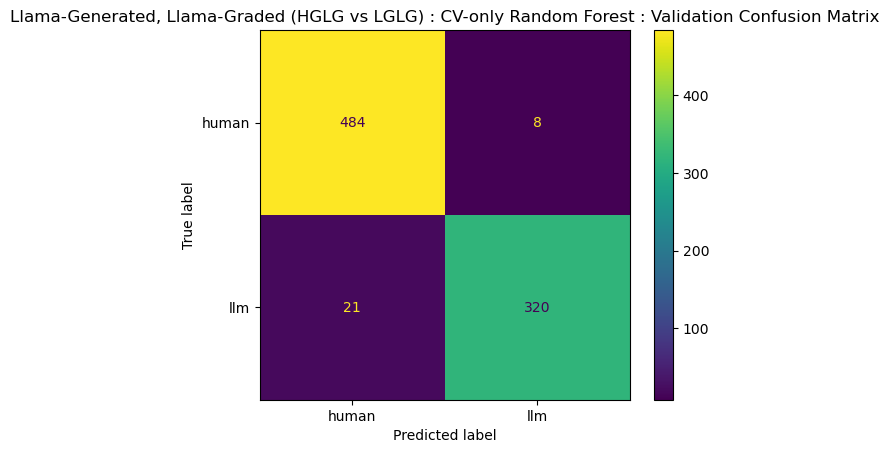

cv_local_mean_w128    0.265876
cv_local_mean_w64     0.156960
cv_local_p75_w128     0.118316
cv_local_p5_w128      0.101501
cv_local_p25_w128     0.100481
cv_local_p25_w64      0.046582
cv_local_mean_w32     0.037613
cv_local_mean_w16     0.031316
cv_local_p75_w64      0.027741
cv_local_p75_w16      0.022655
cv_local_p25_w16      0.021813
cv_local_p5_w64       0.020532
cv_local_p5_w16       0.016161
cv_local_p75_w32      0.013443
cv_local_p25_w32      0.011320
cv_local_p5_w32       0.007692
dtype: float64

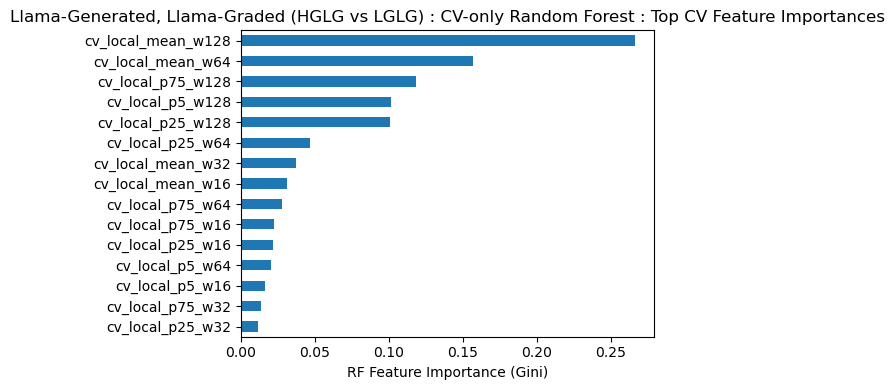

In [87]:
# Run RF on CV features only
cv_rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=cv_features,
    title='Llama-Generated, Llama-Graded (HGLG vs LGLG) : CV-only Random Forest'
)


## All Features

Now we repeat the same procedure using **All features**.


Llama-Generated, Llama-Graded (HGLG vs LGLG) : All Features Random Forest
accuracy (val):        0.970
precision_macro (val): 0.970
recall_macro (val):    0.968
f1_macro (val):        0.969
AUROC (val):           0.997


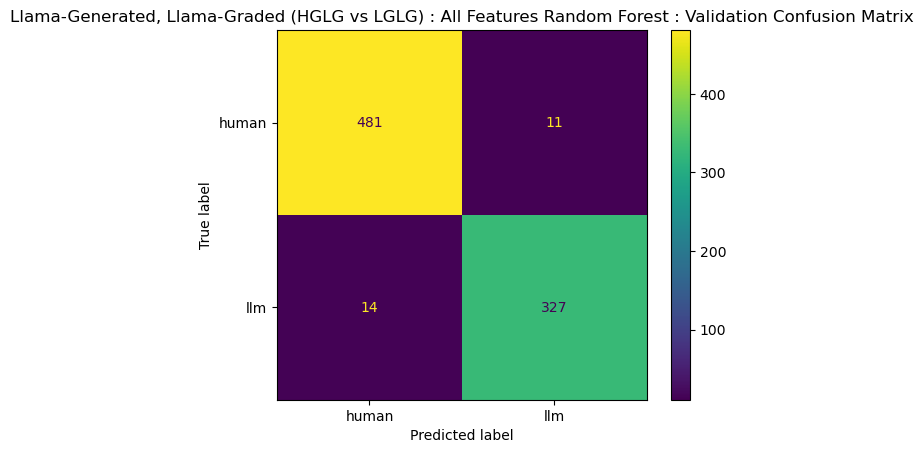

cv_local_mean_w128    0.141790
cv_local_p25_w128     0.105584
cv_local_p75_w128     0.098035
acf_abs_sum_L64       0.086519
cv_local_mean_w64     0.086362
cv_local_p5_w128      0.081184
cv_local_mean_w32     0.053883
cv_local_p75_w64      0.041315
cv_local_p25_w64      0.039318
vfd_local_p5_n1       0.027733
vfd_local_p25_n1      0.027714
vfd_local_p75_n1      0.025963
vfd_local_mean_n1     0.025061
cv_local_p25_w32      0.019518
cv_local_p5_w64       0.016619
cv_local_mean_w16     0.015453
cv_local_p75_w32      0.013782
vfd_local_p75_n2      0.012351
vfd_local_p25_n2      0.011011
acf_lag2              0.010887
dtype: float64

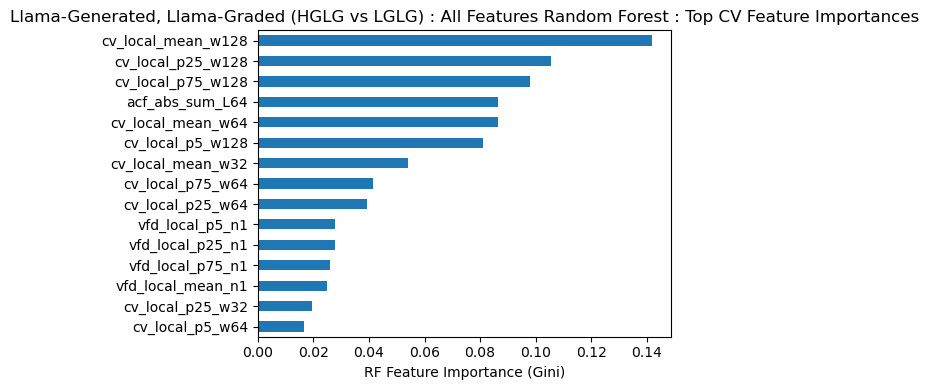

In [88]:
# Run RF on ACF features only
all_features = cv_features + acf_features + vfd_features + scr_features
cv_rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=all_features,
    title='Llama-Generated, Llama-Graded (HGLG vs LGLG) : All Features Random Forest'
)

## RESULTS (Reuters Mixtral-Generated, Llama-Graded)
0.97 F1 score for Mixtral-Generated, Llama-Graded.  Almost perfect separation.

# <a color="red"><u>HC3</u></a>

## Llama-Graded

## Build Stats-Only Feature DataFrame

We now build a dataframe of features for HC3 Llama-Graded:


In [44]:
# Build the core dataframe for HGMG vs LGMG
df_stats_llama = build_stats_feature_df(HUMAN_HC3_LLAMA, LLM_HC3_LLAMA)
df_stats_llama.head()


/opt/anaconda3/envs/llm-fp/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,cv_local_mean_w16,cv_local_p5_w16,cv_local_p25_w16,cv_local_p75_w16,cv_local_mean_w32,cv_local_p5_w32,cv_local_p25_w32,cv_local_p75_w32,cv_local_mean_w64,cv_local_p5_w64,...,vfd_local_p25_n2,vfd_local_p75_n2,scr_local_mean_w4,scr_local_std_w4,scr_local_mean_w16,scr_local_std_w16,scr_local_mean_w64,scr_local_std_w64,label,doc_id
0,1.027912,0.718343,0.861630,0.861630,1.038384,0.848019,0.947114,0.947114,1.071279,0.986407,...,14.675414,14.675414,0.663043,0.302493,0.664502,0.114127,0.662442,0.050000,human,human_0
1,0.988547,0.653463,0.866465,0.866465,0.996679,0.765678,0.930111,0.930111,1.002622,0.823366,...,14.833491,14.833491,0.693548,0.295684,0.691050,0.093404,0.686380,0.039979,human,human_1
2,0.954696,0.540628,0.854147,0.854147,0.953587,0.676595,0.855188,0.855188,0.948023,0.794190,...,23.646550,23.646550,0.678333,0.312553,0.674603,0.116779,0.670968,0.039882,human,human_2
3,0.844232,0.634487,0.738796,0.738796,0.874402,0.732586,0.799523,0.799523,0.892658,0.798789,...,17.693392,17.693392,0.628012,0.310002,0.624107,0.100851,0.622391,0.046348,human,human_3
4,0.971360,0.709197,0.852829,0.852829,0.979838,0.836441,0.903298,0.903298,0.983332,0.903429,...,18.570739,18.570739,0.645105,0.300457,0.637681,0.086028,0.635484,0.035442,human,human_4


## Train / Validation Split

## Per-Feature Threshold Search Utilities

For each scalar feature, we search over candidate thresholds and directions
(`>=` vs `<=`) on the **training** set to maximize macro-F₁, then evaluate that
single-threshold classifier on both train and validation splits.


## CV Deep Dive: Threshold Search and Random Forest

We now isolate **CV features** (`cv_local_mean_w*`) and:

1. Run a per-feature threshold search.
2. Train a Random Forest classifier using only these CV features.


In [45]:
# Split train/validation
train_stats, val_stats = stratified_train_val_split(df_stats_llama, test_size=0.2, seed=42)

# Identify CV feature columns (all CV-related stats)
cv_features = [c for c in df_stats_llama.columns if c.startswith('cv_local_')]

# Run threshold search for each CV feature
cv_results = []
for feat in cv_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    cv_results.append(res.__dict__)

cv_results_df = pd.DataFrame(cv_results).sort_values('val_f1_macro', ascending=False)
cv_results_df


,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
0,cv_local_mean_w16,<=,1.205493,False,0.912293,0.910808,0.918241,0.904577,0.918855,0.911716,NaN,0.917855,0.915776,0.922956,0.909887,0.924528,0.917208,NaN
2,cv_local_p25_w16,<=,1.025635,False,0.904307,0.901474,0.906711,0.893034,0.913431,0.903232,NaN,0.908728,0.905874,0.910962,0.897698,0.917611,0.907654,NaN
3,cv_local_p75_w16,<=,1.025635,False,0.904307,0.901474,0.906711,0.893034,0.913431,0.903232,NaN,0.908728,0.905874,0.910962,0.897698,0.917611,0.907654,NaN
4,cv_local_mean_w32,<=,1.246244,False,0.882630,0.884258,0.891295,0.875511,0.888979,0.882245,NaN,0.881346,0.882043,0.889243,0.873325,0.888412,0.880869,NaN
6,cv_local_p25_w32,<=,1.080461,False,0.872932,0.875669,0.882283,0.866116,0.879088,0.872602,NaN,0.874501,0.877330,0.884011,0.867788,0.880565,0.874177,NaN
7,cv_local_p75_w32,<=,1.080461,False,0.872932,0.875669,0.882283,0.866116,0.879088,0.872602,NaN,0.874501,0.877330,0.884011,0.867788,0.880565,0.874177,NaN
1,cv_local_p5_w16,<=,0.837183,False,0.850970,0.848074,0.853201,0.834521,0.864444,0.849483,NaN,0.854535,0.851714,0.857090,0.838710,0.867532,0.853121,NaN
5,cv_local_p5_w32,<=,0.958301,False,0.827724,0.827685,0.833839,0.815121,0.838718,0.826920,NaN,0.832858,0.832517,0.838806,0.820135,0.843900,0.832017,NaN
8,cv_local_mean_w64,<=,1.254133,False,0.824444,0.841888,0.840735,0.825464,0.823411,0.824438,NaN,0.816885,0.835041,0.833467,0.818336,0.815411,0.816874,NaN
10,cv_local_p25_w64,<=,1.152633,False,0.814461,0.829801,0.829775,0.814487,0.814434,0.814461,NaN,0.804906,0.821067,0.820547,0.805461,0.804348,0.804904,NaN


In [46]:
# Identify ACF feature columns (all ACF-related stats)
acf_features = [c for c in df_stats_llama.columns if c.startswith('acf_')]

# Run threshold search for each ACF feature
acf_results = []
for feat in acf_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    acf_results.append(res.__dict__)

acf_results_df = pd.DataFrame(acf_results).sort_values('val_f1_macro', ascending=False)
acf_results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
1,acf_lag2,<=,0.070080,False,0.651312,0.647676,0.649873,0.613072,0.682674,0.647873,0.298679,0.641757,0.638967,0.641312,0.606023,0.671548,0.638785,0.313692
2,acf_lag4,<=,0.066006,False,0.579578,0.566976,0.564148,0.480803,0.646777,0.563790,0.397241,0.580148,0.567131,0.563955,0.478014,0.648855,0.563435,0.402799
3,acf_lag8,>=,-0.505912,True,0.567884,0.283942,0.500000,0.000000,0.724395,0.362198,0.418122,0.568169,0.284084,0.500000,0.000000,0.724627,0.362314,0.445294
0,acf_abs_sum_L64,>=,1.005706,True,0.567884,0.283942,0.500000,0.000000,0.724395,0.362198,0.529924,0.567028,0.283838,0.498996,0.000000,0.723699,0.361849,0.529310


In [47]:
# Identify VFD feature columns (all vfd-related stats)
vfd_features = [c for c in df_stats_llama.columns if c.startswith('vfd_local_')]

# Run threshold search for each vfd feature
vfd_results = []
for feat in vfd_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    vfd_results.append(res.__dict__)

vfd_results_df = pd.DataFrame(vfd_results).sort_values('val_f1_macro', ascending=False)
vfd_results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
0,vfd_local_mean_n1,>=,3.546233,False,0.940388,0.938132,0.941280,0.932165,0.946833,0.939499,0.975076,0.941814,0.939345,0.943406,0.934109,0.947906,0.941007,0.976335
1,vfd_local_p5_n1,>=,3.546233,False,0.940388,0.938132,0.941280,0.932165,0.946833,0.939499,0.975076,0.941814,0.939345,0.943406,0.934109,0.947906,0.941007,0.976335
2,vfd_local_p25_n1,>=,3.546233,False,0.940388,0.938132,0.941280,0.932165,0.946833,0.939499,0.975076,0.941814,0.939345,0.943406,0.934109,0.947906,0.941007,0.976335
3,vfd_local_p75_n1,>=,3.546233,False,0.940388,0.938132,0.941280,0.932165,0.946833,0.939499,0.975076,0.941814,0.939345,0.943406,0.934109,0.947906,0.941007,0.976335
4,vfd_local_mean_n2,>=,9.739519,False,0.930262,0.927984,0.930708,0.920475,0.937905,0.929190,0.968585,0.929835,0.927177,0.931596,0.920798,0.937020,0.928909,0.970561
5,vfd_local_p5_n2,>=,9.739519,False,0.930262,0.927984,0.930708,0.920475,0.937905,0.929190,0.968585,0.929835,0.927177,0.931596,0.920798,0.937020,0.928909,0.970561
6,vfd_local_p25_n2,>=,9.739519,False,0.930262,0.927984,0.930708,0.920475,0.937905,0.929190,0.968585,0.929835,0.927177,0.931596,0.920798,0.937020,0.928909,0.970561
7,vfd_local_p75_n2,>=,9.739519,False,0.930262,0.927984,0.930708,0.920475,0.937905,0.929190,0.968585,0.929835,0.927177,0.931596,0.920798,0.937020,0.928909,0.970561


In [48]:
# Identify SCR feature columns (all scr-related stats)
scr_features = [c for c in df_stats_llama.columns if c.startswith('scr_local_')]

# Run threshold search for each scr feature
scr_results = []
for feat in scr_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    scr_results.append(res.__dict__)

scr_results_df = pd.DataFrame(scr_results).sort_values('val_f1_macro', ascending=False)
scr_results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
4,scr_local_mean_w64,<=,0.646580,False,0.485881,0.499552,0.499562,0.502278,0.468367,0.485323,NaN,0.449515,0.462251,0.463259,0.469489,0.427979,0.448734,NaN
5,scr_local_std_w64,<=,0.025704,False,0.480034,0.599955,0.535483,0.610720,0.217261,0.413990,NaN,0.473474,0.591772,0.530148,0.608068,0.198089,0.403078,NaN
1,scr_local_std_w4,>=,0.000000,True,0.567884,0.283942,0.500000,0.000000,0.724395,0.362198,0.474393,0.568169,0.284084,0.500000,0.000000,0.724627,0.362314,0.472667
0,scr_local_mean_w4,>=,0.361111,True,0.567884,0.283942,0.500000,0.000000,0.724395,0.362198,0.454606,0.567028,0.283838,0.498996,0.000000,0.723699,0.361849,0.492490
2,scr_local_mean_w16,>=,0.321429,False,0.555334,0.281196,0.488950,0.000000,0.714102,0.357051,NaN,0.556760,0.281593,0.489960,0.000000,0.715280,0.357640,NaN
3,scr_local_std_w16,>=,0.000000,False,0.549487,0.287429,0.483881,0.001265,0.709143,0.355204,NaN,0.547633,0.279557,0.481928,0.000000,0.707704,0.353852,NaN


Llama-Graded HC3 : CV-only Random Forest
accuracy (val):        0.951
precision_macro (val): 0.949
recall_macro (val):    0.951
f1_macro (val):        0.950
AUROC (val):           0.989


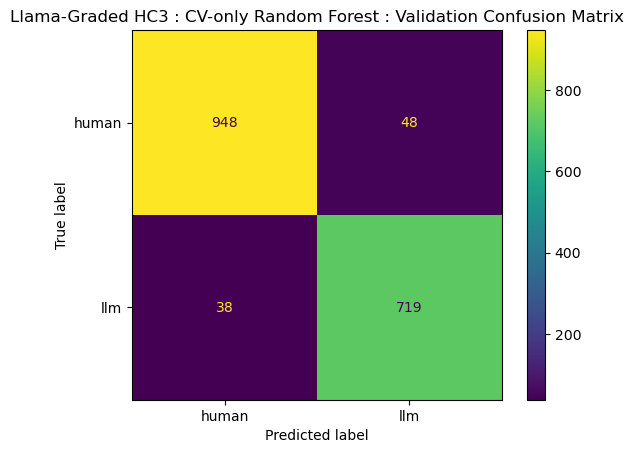

cv_local_mean_w32     0.187818
cv_local_mean_w16     0.182789
cv_local_p25_w16      0.112551
cv_local_p75_w16      0.112460
cv_local_mean_w64     0.104044
cv_local_p5_w128      0.055101
cv_local_p75_w32      0.044167
cv_local_p75_w64      0.036414
cv_local_p25_w64      0.035295
cv_local_p25_w32      0.034390
cv_local_p25_w128     0.021315
cv_local_mean_w128    0.021313
cv_local_p75_w128     0.018176
cv_local_p5_w64       0.012239
cv_local_p5_w16       0.011732
cv_local_p5_w32       0.010196
dtype: float64

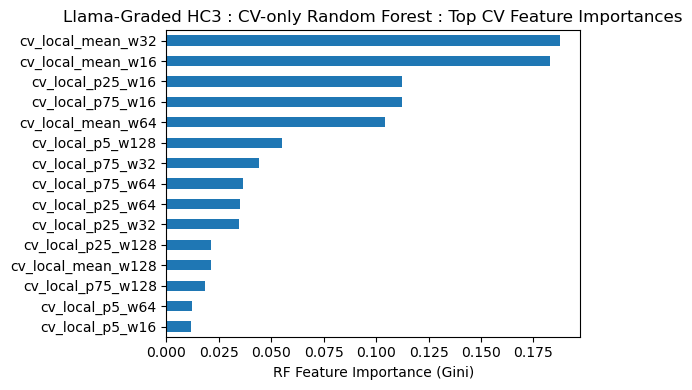

In [51]:
# Run RF on CV features only
cv_rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=cv_features,
    title='Llama-Graded HC3 : CV-only Random Forest'
)


## All Features

Now we repeat the same procedure using **All features**.


Llama-Graded HC3 : All Features Random Forest
accuracy (val):        0.985
precision_macro (val): 0.984
recall_macro (val):    0.985
f1_macro (val):        0.984
AUROC (val):           0.999


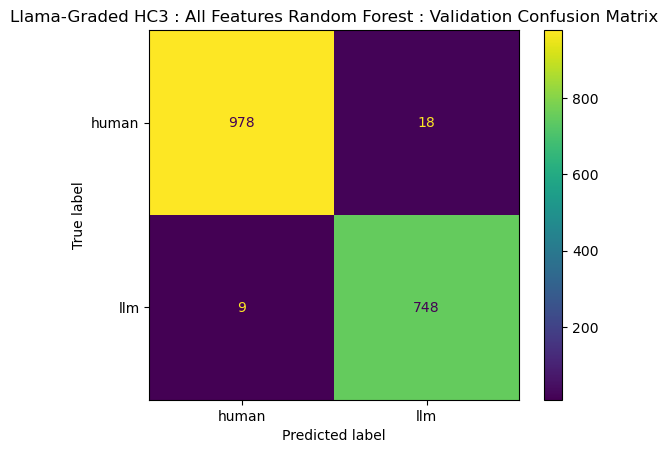

vfd_local_p25_n1      0.120191
vfd_local_mean_n1     0.109619
vfd_local_p5_n1       0.106317
vfd_local_p75_n1      0.089398
vfd_local_p25_n2      0.061528
vfd_local_mean_n2     0.059357
vfd_local_p75_n2      0.055606
cv_local_mean_w16     0.050904
cv_local_p25_w16      0.042104
vfd_local_p5_n2       0.041731
cv_local_mean_w32     0.040964
cv_local_p75_w16      0.038244
cv_local_p5_w128      0.025724
cv_local_mean_w64     0.024069
cv_local_p25_w32      0.014869
cv_local_mean_w128    0.014629
cv_local_p25_w128     0.013837
cv_local_p75_w128     0.012889
cv_local_p75_w32      0.011683
cv_local_p75_w64      0.011261
dtype: float64

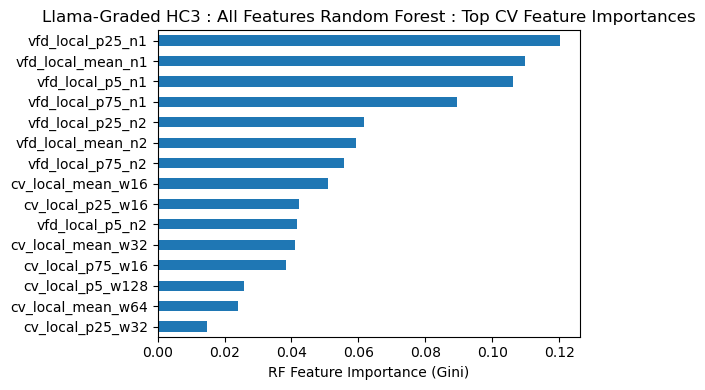

In [52]:
# Run RF on ACF features only
all_features = cv_features + acf_features + vfd_features + scr_features
cv_rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=all_features,
    title='Llama-Graded HC3 : All Features Random Forest'
)

## RESULTS (HC3, Llama-Graded)
0.984 F1 score.  Almost perfect separation.

# <a color="red"><u>HC3</u></a>

## Mixtral-Graded

## Build Stats-Only Feature DataFrame

We now build a dataframe of features for HC3 Mixtral-Graded:


In [53]:
# Build the core dataframe for HGMG vs LGMG
df_stats_mixtral = build_stats_feature_df(HUMAN_HC3_MIXTRAL, LLM_HC3_MIXTRAL)
df_stats_mixtral.head()


/opt/anaconda3/envs/llm-fp/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,cv_local_mean_w16,cv_local_p5_w16,cv_local_p25_w16,cv_local_p75_w16,cv_local_mean_w32,cv_local_p5_w32,cv_local_p25_w32,cv_local_p75_w32,cv_local_mean_w64,cv_local_p5_w64,...,vfd_local_p25_n2,vfd_local_p75_n2,scr_local_mean_w4,scr_local_std_w4,scr_local_mean_w16,scr_local_std_w16,scr_local_mean_w64,scr_local_std_w64,label,doc_id
0,1.069134,0.693529,0.833472,0.833472,1.087818,0.798234,0.930123,0.930123,1.106665,0.949618,...,15.517005,15.517005,0.644330,0.307594,0.642857,0.124016,0.640860,0.062902,human,human_0
1,1.129293,0.685561,0.953322,0.953322,1.125058,0.709326,1.067179,1.067179,1.135100,0.833271,...,15.832678,15.832678,0.673522,0.313104,0.675940,0.118249,0.672043,0.052595,human,human_1
2,1.097799,0.611129,0.930746,0.930746,1.089123,0.762504,0.949876,0.949876,1.091981,0.882266,...,25.459371,25.459371,0.655325,0.303762,0.656794,0.108495,0.653226,0.030427,human,human_2
3,0.988278,0.698608,0.848093,0.848093,1.011332,0.831937,0.899579,0.899579,1.011580,0.877956,...,20.870679,20.870679,0.593496,0.310699,0.597619,0.104612,0.593548,0.049534,human,human_3
4,1.098683,0.766988,0.906895,0.906895,1.108347,0.878960,0.984288,0.984288,1.115587,0.975988,...,20.705132,20.705132,0.650000,0.308195,0.641002,0.129017,0.642315,0.052647,human,human_4


## Train / Validation Split

## Per-Feature Threshold Search Utilities

For each scalar feature, we search over candidate thresholds and directions
(`>=` vs `<=`) on the **training** set to maximize macro-F₁, then evaluate that
single-threshold classifier on both train and validation splits.


## CV Deep Dive: Threshold Search and Random Forest

We now isolate **CV features** (`cv_local_mean_w*`) and:

1. Run a per-feature threshold search.
2. Train a Random Forest classifier using only these CV features.


In [54]:
# Split train/validation
train_stats, val_stats = stratified_train_val_split(df_stats_mixtral, test_size=0.2, seed=42)

# Identify CV feature columns (all CV-related stats)
cv_features = [c for c in df_stats_mixtral.columns if c.startswith('cv_local_')]

# Run threshold search for each CV feature
cv_results = []
for feat in cv_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    cv_results.append(res.__dict__)

cv_results_df = pd.DataFrame(cv_results).sort_values('val_f1_macro', ascending=False)
cv_results_df


,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
0,cv_local_mean_w16,<=,1.437184,False,0.957553,0.943942,0.962832,0.936601,0.968096,0.952348,NaN,0.958510,0.944654,0.964585,0.938131,0.968790,0.953461,NaN
2,cv_local_p25_w16,<=,1.147127,False,0.957341,0.944489,0.961021,0.935920,0.968029,0.951974,NaN,0.958086,0.944947,0.962528,0.937143,0.968561,0.952852,NaN
3,cv_local_p75_w16,<=,1.147127,False,0.957341,0.944489,0.961021,0.935920,0.968029,0.951974,NaN,0.958086,0.944947,0.962528,0.937143,0.968561,0.952852,NaN
4,cv_local_mean_w32,<=,1.445336,False,0.919445,0.899394,0.937743,0.887309,0.937320,0.912315,NaN,0.918290,0.898187,0.937433,0.886001,0.936325,0.911163,NaN
6,cv_local_p25_w32,<=,1.252234,False,0.918175,0.898063,0.930798,0.883356,0.936985,0.910171,NaN,0.917866,0.897606,0.932933,0.883832,0.936477,0.910155,NaN
7,cv_local_p75_w32,<=,1.252234,False,0.918175,0.898063,0.930798,0.883356,0.936985,0.910171,NaN,0.917866,0.897606,0.932933,0.883832,0.936477,0.910155,NaN
1,cv_local_p5_w16,<=,0.922891,False,0.899227,0.884040,0.884973,0.843266,0.925741,0.884504,NaN,0.904742,0.888920,0.893962,0.853229,0.929489,0.891359,NaN
5,cv_local_p5_w32,<=,1.038671,False,0.872340,0.849408,0.877201,0.817383,0.901871,0.859627,NaN,0.874682,0.852011,0.882662,0.822329,0.903205,0.862767,NaN
8,cv_local_mean_w64,<=,1.477299,False,0.847782,0.836749,0.884470,0.806147,0.874695,0.840421,NaN,0.846740,0.836351,0.884436,0.805376,0.873603,0.839490,NaN
10,cv_local_p25_w64,<=,1.335968,False,0.846089,0.832844,0.878955,0.801799,0.874200,0.838000,NaN,0.847163,0.834677,0.881606,0.803911,0.874783,0.839347,NaN


In [55]:
# Identify ACF feature columns (all ACF-related stats)
acf_features = [c for c in df_stats_mixtral.columns if c.startswith('acf_')]

# Run threshold search for each ACF feature
acf_results = []
for feat in acf_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    acf_results.append(res.__dict__)

acf_results_df = pd.DataFrame(acf_results).sort_values('val_f1_macro', ascending=False)
acf_results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
0,acf_abs_sum_L64,>=,0.729383,True,0.679263,0.339632,0.5,0.0,0.809002,0.404501,0.626470,0.679509,0.339754,0.5,0.0,0.809176,0.404588,0.644934
1,acf_lag2,>=,-0.683372,True,0.679263,0.339632,0.5,0.0,0.809002,0.404501,0.385157,0.679509,0.339754,0.5,0.0,0.809176,0.404588,0.412569
2,acf_lag4,>=,-0.525539,True,0.679263,0.339632,0.5,0.0,0.809002,0.404501,0.476015,0.679509,0.339754,0.5,0.0,0.809176,0.404588,0.473907
3,acf_lag8,>=,-0.457448,True,0.679263,0.339632,0.5,0.0,0.809002,0.404501,0.483862,0.679509,0.339754,0.5,0.0,0.809176,0.404588,0.503262


In [56]:
# Identify VFD feature columns (all vfd-related stats)
vfd_features = [c for c in df_stats_mixtral.columns if c.startswith('vfd_local_')]

# Run threshold search for each vfd feature
vfd_results = []
for feat in vfd_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    vfd_results.append(res.__dict__)

vfd_results_df = pd.DataFrame(vfd_results).sort_values('val_f1_macro', ascending=False)
vfd_results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
0,vfd_local_mean_n1,>=,4.200252,False,0.79295,0.773312,0.729835,0.631777,0.855986,0.743881,0.801242,0.785775,0.769088,0.713596,0.605304,0.852992,0.729148,0.806025
1,vfd_local_p5_n1,>=,4.200252,False,0.79295,0.773312,0.729835,0.631777,0.855986,0.743881,0.801242,0.785775,0.769088,0.713596,0.605304,0.852992,0.729148,0.806025
2,vfd_local_p25_n1,>=,4.200252,False,0.79295,0.773312,0.729835,0.631777,0.855986,0.743881,0.801242,0.785775,0.769088,0.713596,0.605304,0.852992,0.729148,0.806025
3,vfd_local_p75_n1,>=,4.200252,False,0.79295,0.773312,0.729835,0.631777,0.855986,0.743881,0.801242,0.785775,0.769088,0.713596,0.605304,0.852992,0.729148,0.806025
4,vfd_local_mean_n2,>=,11.245318,False,0.77739,0.751962,0.712197,0.604476,0.845106,0.724791,0.780393,0.770110,0.745428,0.697184,0.579396,0.841829,0.710613,0.784277
5,vfd_local_p5_n2,>=,11.245318,False,0.77739,0.751962,0.712197,0.604476,0.845106,0.724791,0.780393,0.770110,0.745428,0.697184,0.579396,0.841829,0.710613,0.784277
6,vfd_local_p25_n2,>=,11.245318,False,0.77739,0.751962,0.712197,0.604476,0.845106,0.724791,0.780393,0.770110,0.745428,0.697184,0.579396,0.841829,0.710613,0.784277
7,vfd_local_p75_n2,>=,11.245318,False,0.77739,0.751962,0.712197,0.604476,0.845106,0.724791,0.780393,0.770110,0.745428,0.697184,0.579396,0.841829,0.710613,0.784277


In [57]:
# Identify SCR feature columns (all scr-related stats)
scr_features = [c for c in df_stats_mixtral.columns if c.startswith('scr_local_')]

# Run threshold search for each scr feature
scr_results = []
for feat in scr_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    scr_results.append(res.__dict__)

scr_results_df = pd.DataFrame(scr_results).sort_values('val_f1_macro', ascending=False)
scr_results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
1,scr_local_std_w4,>=,0.000000,True,0.679263,0.339632,0.500000,0.000000,0.809002,0.404501,0.466260,0.679509,0.339754,0.500000,0.000000,0.809176,0.404588,0.483093
0,scr_local_mean_w4,>=,0.277778,True,0.679263,0.339632,0.500000,0.000000,0.809002,0.404501,0.416979,0.679086,0.339687,0.499688,0.000000,0.808875,0.404438,0.426691
2,scr_local_mean_w16,>=,0.357143,False,0.666455,0.337551,0.490572,0.000000,0.799848,0.399924,NaN,0.665114,0.337414,0.489408,0.000000,0.798881,0.399441,NaN
3,scr_local_std_w16,>=,0.000000,False,0.657775,0.336110,0.484183,0.000000,0.793564,0.396782,NaN,0.656647,0.336005,0.483178,0.000000,0.792742,0.396371,NaN
4,scr_local_mean_w64,>=,0.491935,False,0.553615,0.318755,0.407947,0.002366,0.712484,0.357425,NaN,0.551228,0.316173,0.405607,0.000000,0.710699,0.355349,NaN
5,scr_local_std_w64,<=,0.092812,False,0.521435,0.317075,0.385740,0.009639,0.684486,0.347062,NaN,0.513548,0.310511,0.378580,0.003469,0.678241,0.340855,NaN


Mixtral-Graded HC3 : CV-only Random Forest
accuracy (val):        0.984
precision_macro (val): 0.980
recall_macro (val):    0.985
f1_macro (val):        0.982
AUROC (val):           0.997


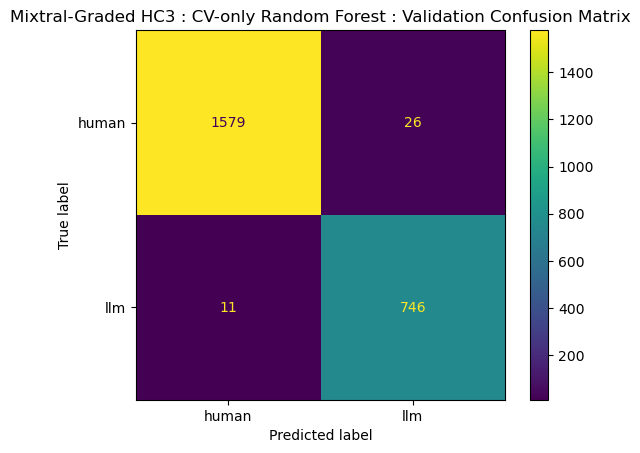

cv_local_p5_w128      0.244953
cv_local_mean_w128    0.168787
cv_local_mean_w64     0.155054
cv_local_p25_w128     0.097519
cv_local_p75_w128     0.085890
cv_local_p25_w64      0.057458
cv_local_mean_w16     0.046536
cv_local_p75_w64      0.039612
cv_local_mean_w32     0.027560
cv_local_p75_w16      0.017802
cv_local_p75_w32      0.017448
cv_local_p25_w16      0.014592
cv_local_p25_w32      0.011369
cv_local_p5_w64       0.005692
cv_local_p5_w32       0.005162
cv_local_p5_w16       0.004567
dtype: float64

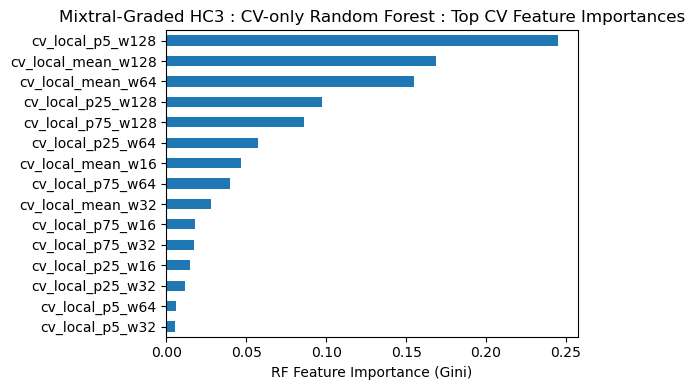

In [58]:
# Run RF on CV features only
cv_rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=cv_features,
    title='Mixtral-Graded HC3 : CV-only Random Forest'
)


## All Features

Now we repeat the same procedure using **All features**.


Mixtral-Graded HC3 : All Features Random Forest
accuracy (val):        0.990
precision_macro (val): 0.988
recall_macro (val):    0.990
f1_macro (val):        0.989
AUROC (val):           0.999


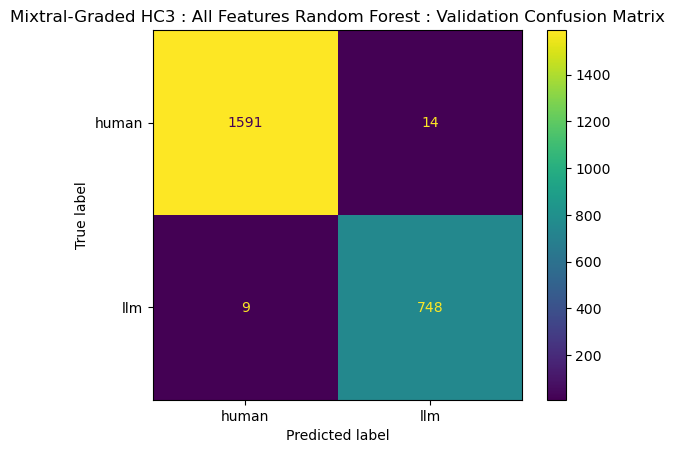

cv_local_p5_w128      0.136440
cv_local_mean_w128    0.110276
cv_local_mean_w64     0.091432
cv_local_p75_w128     0.085647
cv_local_p25_w128     0.083497
cv_local_mean_w32     0.076770
cv_local_mean_w16     0.064734
cv_local_p25_w64      0.061860
cv_local_p75_w64      0.047425
cv_local_p25_w32      0.035974
cv_local_p25_w16      0.035212
cv_local_p75_w16      0.033189
cv_local_p75_w32      0.027574
cv_local_p5_w64       0.019660
cv_local_p5_w16       0.015057
cv_local_p5_w32       0.011281
acf_abs_sum_L64       0.008536
vfd_local_p75_n1      0.007718
vfd_local_mean_n1     0.006599
vfd_local_p5_n1       0.006466
dtype: float64

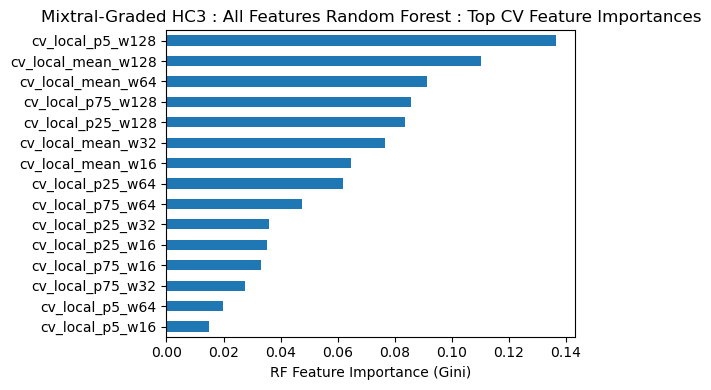

In [59]:
# Run RF on ACF features only
all_features = cv_features + acf_features + vfd_features + scr_features
cv_rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=all_features,
    title='Mixtral-Graded HC3 : All Features Random Forest'
)

## RESULTS (HC3, Mixtral-Graded)
0.989 F1 score.  Almost perfect separation.

# <a color="red"><u>MAGE</u></a>

## Llama-Graded

## Build Stats-Only Feature DataFrame

We now build a dataframe of features for MAGE Llama-Graded:


In [60]:
# Build the core dataframe for HGMG vs LGMG
df_stats_llama = build_stats_feature_df(HUMAN_MAGE_LLAMA, LLM_MAGE_LLAMA)
df_stats_llama.head()


,cv_local_mean_w16,cv_local_p5_w16,cv_local_p25_w16,cv_local_p75_w16,cv_local_mean_w32,cv_local_p5_w32,cv_local_p25_w32,cv_local_p75_w32,cv_local_mean_w64,cv_local_p5_w64,...,vfd_local_p25_n2,vfd_local_p75_n2,scr_local_mean_w4,scr_local_std_w4,scr_local_mean_w16,scr_local_std_w16,scr_local_mean_w64,scr_local_std_w64,label,doc_id
0,1.244486,0.920967,1.052675,1.052675,1.246806,1.006678,1.150219,1.150219,1.278861,1.190185,...,6.993359,6.993359,0.678295,0.316833,0.677419,0.111816,0.682382,0.044360,human,human_0
1,1.188239,0.796274,0.953168,0.953168,1.218473,0.976234,1.051059,1.051059,1.211474,1.007808,...,6.684523,6.684523,0.657807,0.327893,0.649706,0.106589,0.654234,0.065574,human,human_1
2,1.132859,0.810516,0.986888,0.986888,1.126458,0.912446,1.046275,1.046275,1.124861,0.980594,...,8.288130,8.288130,0.648693,0.326353,0.649614,0.118329,0.637097,0.029447,human,human_2
3,0.782246,0.581848,0.689871,0.689871,0.792862,0.668018,0.721281,0.721281,0.797213,0.741669,...,13.583115,13.583115,0.677201,0.305825,0.673942,0.086398,0.680780,0.024242,human,human_3
4,0.727537,0.513259,0.633692,0.633692,0.737720,0.580695,0.664216,0.664216,0.743776,0.638868,...,12.191806,12.191806,0.660998,0.312865,0.661376,0.097347,0.664651,0.045116,human,human_4


## Train / Validation Split

## Per-Feature Threshold Search Utilities

For each scalar feature, we search over candidate thresholds and directions
(`>=` vs `<=`) on the **training** set to maximize macro-F₁, then evaluate that
single-threshold classifier on both train and validation splits.


## CV Deep Dive: Threshold Search and Random Forest

We now isolate **CV features** (`cv_local_mean_w*`) and:

1. Run a per-feature threshold search.
2. Train a Random Forest classifier using only these CV features.


In [61]:
# Split train/validation
train_stats, val_stats = stratified_train_val_split(df_stats_llama, test_size=0.2, seed=42)

# Identify CV feature columns (all CV-related stats)
cv_features = [c for c in df_stats_llama.columns if c.startswith('cv_local_')]

# Run threshold search for each CV feature
cv_results = []
for feat in cv_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    cv_results.append(res.__dict__)

cv_results_df = pd.DataFrame(cv_results).sort_values('val_f1_macro', ascending=False)
cv_results_df


,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
5,cv_local_p5_w32,<=,0.683311,False,0.666667,0.757813,0.671145,0.740053,0.535545,0.637799,0.369391,0.675170,0.767456,0.679114,0.746348,0.548463,0.647406,0.372715
10,cv_local_p25_w64,<=,0.818697,False,0.663690,0.756075,0.668214,0.738339,0.529447,0.633893,0.396537,0.675170,0.767456,0.679114,0.746348,0.548463,0.647406,0.394399
11,cv_local_p75_w64,<=,0.818697,False,0.663690,0.756075,0.668214,0.738339,0.529447,0.633893,0.396537,0.675170,0.767456,0.679114,0.746348,0.548463,0.647406,0.394399
6,cv_local_p25_w32,<=,0.799288,False,0.665816,0.746918,0.670125,0.737124,0.541424,0.639274,0.394377,0.671769,0.747976,0.675480,0.740242,0.554273,0.647257,0.392247
7,cv_local_p75_w32,<=,0.799288,False,0.665816,0.746918,0.670125,0.737124,0.541424,0.639274,0.394377,0.671769,0.747976,0.675480,0.740242,0.554273,0.647257,0.392247
2,cv_local_p25_w16,<=,0.745274,False,0.665816,0.760530,0.670360,0.740251,0.531585,0.635918,0.398894,0.673469,0.766511,0.677436,0.745358,0.545024,0.645191,0.398091
3,cv_local_p75_w16,<=,0.745274,False,0.665816,0.760530,0.670360,0.740251,0.531585,0.635918,0.398894,0.673469,0.766511,0.677436,0.745358,0.545024,0.645191,0.398091
13,cv_local_p5_w128,<=,0.790234,False,0.661990,0.763484,0.666669,0.739088,0.520217,0.629652,0.369886,0.673469,0.773184,0.677528,0.746702,0.540670,0.643686,0.369452
9,cv_local_p5_w64,<=,0.740132,False,0.663690,0.761831,0.668305,0.739546,0.525495,0.632520,0.362457,0.670068,0.764617,0.674080,0.743386,0.538095,0.640741,0.364395
1,cv_local_p5_w16,<=,0.599299,False,0.662415,0.763716,0.667088,0.739330,0.521110,0.630220,0.375464,0.668367,0.760425,0.672356,0.741722,0.536817,0.639269,0.366073


In [62]:
# Identify ACF feature columns (all ACF-related stats)
acf_features = [c for c in df_stats_llama.columns if c.startswith('acf_')]

# Run threshold search for each ACF feature
acf_results = []
for feat in acf_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    acf_results.append(res.__dict__)

acf_results_df = pd.DataFrame(acf_results).sort_values('val_f1_macro', ascending=False)
acf_results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
2,acf_lag4,>=,0.053784,False,0.632653,0.643828,0.634624,0.671733,0.583012,0.627372,0.667428,0.620748,0.633908,0.622738,0.666667,0.560158,0.613412,0.658864
1,acf_lag2,>=,0.049922,False,0.629677,0.630320,0.630065,0.635412,0.623758,0.629585,0.671161,0.608844,0.609671,0.609280,0.617940,0.599303,0.608622,0.653576
3,acf_lag8,>=,0.052277,False,0.605017,0.619149,0.607444,0.656308,0.535732,0.596020,0.642026,0.588435,0.602041,0.590720,0.645161,0.510121,0.577641,0.613307
0,acf_abs_sum_L64,>=,3.032624,False,0.617772,0.662712,0.621647,0.692650,0.494660,0.593655,0.674390,0.576531,0.610958,0.580132,0.663058,0.430206,0.546632,0.632006


In [63]:
# Identify VFD feature columns (all vfd-related stats)
vfd_features = [c for c in df_stats_llama.columns if c.startswith('vfd_local_')]

# Run threshold search for each vfd feature
vfd_results = []
for feat in vfd_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    vfd_results.append(res.__dict__)

vfd_results_df = pd.DataFrame(vfd_results).sort_values('val_f1_macro', ascending=False)
vfd_results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
0,vfd_local_mean_n1,<=,4.744644,False,0.802296,0.803718,0.802803,0.806331,0.798089,0.802210,0.118891,0.77381,0.778567,0.774670,0.785137,0.761221,0.773179,0.145881
1,vfd_local_p5_n1,<=,4.744644,False,0.802296,0.803718,0.802803,0.806331,0.798089,0.802210,0.118891,0.77381,0.778567,0.774670,0.785137,0.761221,0.773179,0.145881
2,vfd_local_p25_n1,<=,4.744644,False,0.802296,0.803718,0.802803,0.806331,0.798089,0.802210,0.118891,0.77381,0.778567,0.774670,0.785137,0.761221,0.773179,0.145881
3,vfd_local_p75_n1,<=,4.744644,False,0.802296,0.803718,0.802803,0.806331,0.798089,0.802210,0.118891,0.77381,0.778567,0.774670,0.785137,0.761221,0.773179,0.145881
4,vfd_local_mean_n2,<=,13.742886,False,0.782738,0.782745,0.782811,0.781156,0.784297,0.782727,0.139554,0.75000,0.750188,0.750162,0.750424,0.749574,0.749999,0.168607
5,vfd_local_p5_n2,<=,13.742886,False,0.782738,0.782745,0.782811,0.781156,0.784297,0.782727,0.139554,0.75000,0.750188,0.750162,0.750424,0.749574,0.749999,0.168607
6,vfd_local_p25_n2,<=,13.742886,False,0.782738,0.782745,0.782811,0.781156,0.784297,0.782727,0.139554,0.75000,0.750188,0.750162,0.750424,0.749574,0.749999,0.168607
7,vfd_local_p75_n2,<=,13.742886,False,0.782738,0.782745,0.782811,0.781156,0.784297,0.782727,0.139554,0.75000,0.750188,0.750162,0.750424,0.749574,0.749999,0.168607


In [64]:
# Identify SCR feature columns (all scr-related stats)
scr_features = [c for c in df_stats_llama.columns if c.startswith('scr_local_')]

# Run threshold search for each scr feature
scr_results = []
for feat in scr_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    scr_results.append(res.__dict__)

scr_results_df = pd.DataFrame(scr_results).sort_values('val_f1_macro', ascending=False)
scr_results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
0,scr_local_mean_w4,>=,0.652896,False,0.536139,0.535770,0.535074,0.497003,0.569625,0.533314,0.530600,0.527211,0.526788,0.526475,0.496377,0.554487,0.525432,0.537943
4,scr_local_mean_w64,>=,0.667368,False,0.536139,0.543920,0.538771,0.601388,0.445348,0.523368,0.530669,0.537415,0.545517,0.539829,0.604651,0.442623,0.523637,0.539568
2,scr_local_mean_w16,>=,0.672260,False,0.534864,0.550544,0.538595,0.623538,0.391546,0.507542,0.528823,0.520408,0.531572,0.523791,0.613699,0.367713,0.490706,0.540303
3,scr_local_std_w16,<=,0.105358,False,0.514881,0.525435,0.518796,0.611244,0.355003,0.483123,0.495850,0.505102,0.510713,0.508320,0.597510,0.357616,0.477563,0.487891
1,scr_local_std_w4,<=,0.305934,False,0.526361,0.552446,0.531236,0.638546,0.313194,0.475870,0.482325,0.517007,0.534956,0.521268,0.630208,0.303922,0.467065,0.478766
5,scr_local_std_w64,>=,0.060243,False,0.514881,0.529818,0.519408,0.623308,0.318806,0.471057,0.504249,0.493197,0.495726,0.497223,0.606860,0.287081,0.446971,0.481665


Llama-Graded MAGE : CV-only Random Forest
accuracy (val):        0.743
precision_macro (val): 0.749
recall_macro (val):    0.744
f1_macro (val):        0.742
AUROC (val):           0.806


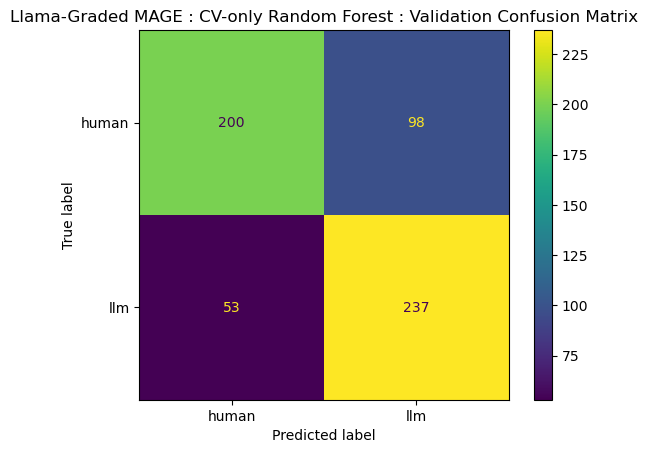

cv_local_p25_w32      0.072582
cv_local_mean_w32     0.072273
cv_local_p25_w16      0.071552
cv_local_p75_w32      0.068650
cv_local_mean_w64     0.065535
cv_local_p75_w16      0.065148
cv_local_p5_w64       0.064663
cv_local_p5_w128      0.064017
cv_local_mean_w128    0.063608
cv_local_mean_w16     0.062746
cv_local_p5_w32       0.062166
cv_local_p5_w16       0.061697
cv_local_p75_w64      0.055590
cv_local_p25_w64      0.055582
cv_local_p25_w128     0.049024
cv_local_p75_w128     0.045168
dtype: float64

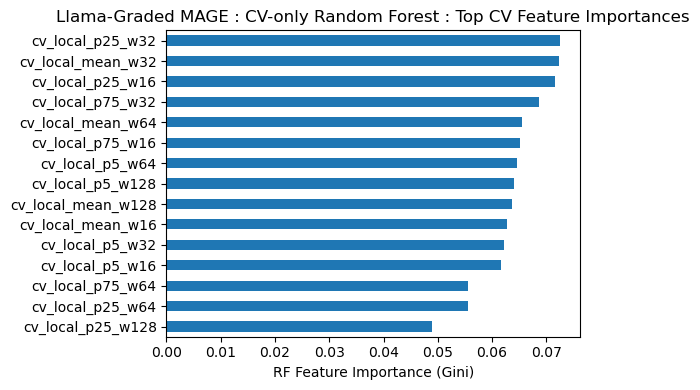

In [65]:
# Run RF on CV features only
cv_rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=cv_features,
    title='Llama-Graded MAGE : CV-only Random Forest'
)


## All Features

Now we repeat the same procedure using **All features**.


Llama-Graded MAGE : All Features Random Forest
accuracy (val):        0.876
precision_macro (val): 0.876
recall_macro (val):    0.876
f1_macro (val):        0.876
AUROC (val):           0.946


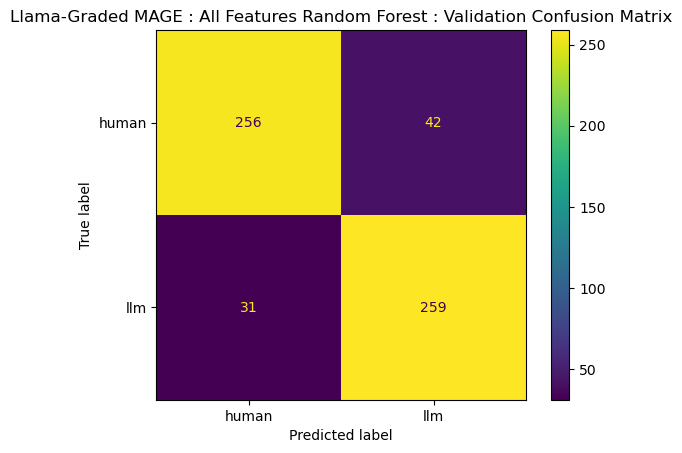

vfd_local_p25_n1     0.094306
vfd_local_p5_n1      0.088630
vfd_local_mean_n1    0.085027
vfd_local_p75_n1     0.070547
vfd_local_mean_n2    0.050560
vfd_local_p75_n2     0.048391
vfd_local_p25_n2     0.041444
cv_local_p25_w32     0.036967
vfd_local_p5_n2      0.035501
cv_local_p75_w32     0.030734
cv_local_p25_w16     0.029913
cv_local_p5_w16      0.028657
cv_local_p75_w16     0.028468
cv_local_p75_w128    0.027435
cv_local_p25_w64     0.024679
cv_local_p75_w64     0.022324
cv_local_p5_w128     0.022150
cv_local_p25_w128    0.021928
cv_local_p5_w64      0.021725
cv_local_p5_w32      0.018687
dtype: float64

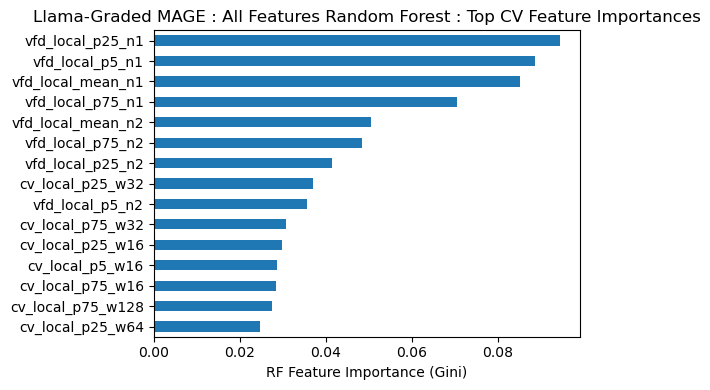

In [66]:
# Run RF on ACF features only
all_features = cv_features + acf_features + vfd_features + scr_features
cv_rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=all_features,
    title='Llama-Graded MAGE : All Features Random Forest'
)

## RESULTS (MAGE, Llama-Graded)
0.876 F1 score.  Variation of Differences appears to be most important

# <a color="red"><u>MAGE</u></a>

## Mixtral-Graded

## Build Stats-Only Feature DataFrame

We now build a dataframe of features for MAGE Mixtral-Graded:


In [67]:
# Build the core dataframe for HGMG vs LGMG
df_stats_mixtral = build_stats_feature_df(HUMAN_MAGE_MIXTRAL, LLM_MAGE_MIXTRAL)
df_stats_mixtral.head()


,cv_local_mean_w16,cv_local_p5_w16,cv_local_p25_w16,cv_local_p75_w16,cv_local_mean_w32,cv_local_p5_w32,cv_local_p25_w32,cv_local_p75_w32,cv_local_mean_w64,cv_local_p5_w64,...,vfd_local_p25_n2,vfd_local_p75_n2,scr_local_mean_w4,scr_local_std_w4,scr_local_mean_w16,scr_local_std_w16,scr_local_mean_w64,scr_local_std_w64,label,doc_id
0,1.359545,0.904481,1.077767,1.077767,1.400633,0.986715,1.087521,1.087521,1.414673,1.055191,...,8.339142,8.339142,0.661473,0.314408,0.661960,0.100075,0.661290,0.035255,human,human_0
1,1.203993,0.794181,0.971521,0.971521,1.183816,0.900072,1.104940,1.104940,1.199909,1.020539,...,5.931506,5.931506,0.664311,0.310053,0.665966,0.131442,0.669355,0.038351,human,human_1
2,1.265012,0.863945,1.045720,1.045720,1.264313,1.003456,1.086442,1.086442,1.279690,1.039014,...,8.323403,8.323403,0.605678,0.316777,0.602968,0.109616,0.602467,0.040700,human,human_2
3,1.374023,0.887693,1.122108,1.122108,1.407652,1.114671,1.213945,1.213945,1.407896,1.229889,...,9.005986,9.005986,0.631661,0.329237,0.628942,0.093447,0.636622,0.050077,human,human_3
4,1.188945,0.803491,1.002170,1.002170,1.196219,0.878290,1.035757,1.035757,1.186942,0.962793,...,7.493580,7.493580,0.670213,0.317037,0.669643,0.098670,0.664137,0.026278,human,human_4


## Train / Validation Split

## Per-Feature Threshold Search Utilities

For each scalar feature, we search over candidate thresholds and directions
(`>=` vs `<=`) on the **training** set to maximize macro-F₁, then evaluate that
single-threshold classifier on both train and validation splits.


## CV Deep Dive: Threshold Search and Random Forest

We now isolate **CV features** (`cv_local_mean_w*`) and:

1. Run a per-feature threshold search.
2. Train a Random Forest classifier using only these CV features.


In [68]:
# Split train/validation
train_stats, val_stats = stratified_train_val_split(df_stats_mixtral, test_size=0.2, seed=42)

# Identify CV feature columns (all CV-related stats)
cv_features = [c for c in df_stats_mixtral.columns if c.startswith('cv_local_')]

# Run threshold search for each CV feature
cv_results = []
for feat in cv_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    cv_results.append(res.__dict__)

cv_results_df = pd.DataFrame(cv_results).sort_values('val_f1_macro', ascending=False)
cv_results_df


,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
9,cv_local_p5_w64,<=,0.858601,False,0.617984,0.659608,0.618036,0.695624,0.487173,0.591398,0.408294,0.613837,0.658424,0.613624,0.695044,0.473684,0.584364,0.413957
13,cv_local_p5_w128,<=,0.919280,False,0.611145,0.654928,0.611198,0.692736,0.470556,0.581646,0.420820,0.616251,0.668797,0.616026,0.700189,0.467039,0.583614,0.415977
5,cv_local_p5_w32,<=,0.789183,False,0.615771,0.660706,0.615825,0.696053,0.477857,0.586955,0.414352,0.603379,0.649293,0.603155,0.689742,0.450390,0.570066,0.424828
1,cv_local_p5_w16,<=,0.704017,False,0.613156,0.659648,0.613211,0.695294,0.470394,0.582844,0.422400,0.601770,0.644741,0.601550,0.687303,0.451827,0.569565,0.428181
6,cv_local_p25_w32,<=,0.889517,False,0.593643,0.659665,0.593708,0.692448,0.401304,0.546876,0.469020,0.590507,0.650640,0.590252,0.689065,0.400471,0.544768,0.468185
7,cv_local_p75_w32,<=,0.889517,False,0.593643,0.659665,0.593708,0.692448,0.401304,0.546876,0.469020,0.590507,0.650640,0.590252,0.689065,0.400471,0.544768,0.468185
2,cv_local_p25_w16,<=,0.843099,False,0.589217,0.654592,0.589283,0.689948,0.391538,0.540743,0.475421,0.588898,0.654335,0.588635,0.690115,0.389486,0.539801,0.476695
3,cv_local_p75_w16,<=,0.843099,False,0.589217,0.654592,0.589283,0.689948,0.391538,0.540743,0.475421,0.588898,0.654335,0.588635,0.690115,0.389486,0.539801,0.476695
10,cv_local_p25_w64,<=,0.910408,False,0.594850,0.677896,0.594919,0.697960,0.384850,0.541405,0.462930,0.588898,0.671090,0.588619,0.694925,0.369914,0.532420,0.464198
11,cv_local_p75_w64,<=,0.910408,False,0.594850,0.677896,0.594919,0.697960,0.384850,0.541405,0.462930,0.588898,0.671090,0.588619,0.694925,0.369914,0.532420,0.464198


In [69]:
# Identify ACF feature columns (all ACF-related stats)
acf_features = [c for c in df_stats_mixtral.columns if c.startswith('acf_')]

# Run threshold search for each ACF feature
acf_results = []
for feat in acf_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    acf_results.append(res.__dict__)

acf_results_df = pd.DataFrame(acf_results).sort_values('val_f1_macro', ascending=False)
acf_results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
1,acf_lag2,>=,0.041758,False,0.600684,0.602110,0.600696,0.622839,0.575764,0.599301,0.635871,0.608206,0.609306,0.608165,0.627391,0.586938,0.607165,0.635998
2,acf_lag4,>=,0.045628,False,0.596459,0.600048,0.596478,0.631250,0.554420,0.592835,0.624218,0.595334,0.601252,0.595236,0.639427,0.538955,0.589191,0.640705
3,acf_lag8,>=,0.040795,False,0.586200,0.590468,0.586222,0.626611,0.535980,0.581296,0.602288,0.589702,0.595032,0.589606,0.633621,0.533821,0.583721,0.609257
0,acf_abs_sum_L64,>=,2.446836,False,0.580768,0.581290,0.580776,0.596749,0.563469,0.580109,0.620247,0.556718,0.556811,0.556700,0.566483,0.546502,0.556493,0.600864


In [70]:
# Identify VFD feature columns (all vfd-related stats)
vfd_features = [c for c in df_stats_mixtral.columns if c.startswith('vfd_local_')]

# Run threshold search for each vfd feature
vfd_results = []
for feat in vfd_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    vfd_results.append(res.__dict__)

vfd_results_df = pd.DataFrame(vfd_results).sort_values('val_f1_macro', ascending=False)
vfd_results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
0,vfd_local_mean_n1,<=,4.201015,False,0.669483,0.733719,0.669536,0.738084,0.552194,0.645139,0.374821,0.670153,0.730475,0.669947,0.737516,0.556277,0.646897,0.376602
1,vfd_local_p5_n1,<=,4.201015,False,0.669483,0.733719,0.669536,0.738084,0.552194,0.645139,0.374821,0.670153,0.730475,0.669947,0.737516,0.556277,0.646897,0.376602
2,vfd_local_p25_n1,<=,4.201015,False,0.669483,0.733719,0.669536,0.738084,0.552194,0.645139,0.374821,0.670153,0.730475,0.669947,0.737516,0.556277,0.646897,0.376602
3,vfd_local_p75_n1,<=,4.201015,False,0.669483,0.733719,0.669536,0.738084,0.552194,0.645139,0.374821,0.670153,0.730475,0.669947,0.737516,0.556277,0.646897,0.376602
4,vfd_local_mean_n2,<=,11.511107,False,0.667270,0.728685,0.667322,0.735698,0.551031,0.643365,0.378377,0.666130,0.725524,0.665924,0.734485,0.550379,0.642432,0.383369
5,vfd_local_p5_n2,<=,11.511107,False,0.667270,0.728685,0.667322,0.735698,0.551031,0.643365,0.378377,0.666130,0.725524,0.665924,0.734485,0.550379,0.642432,0.383369
6,vfd_local_p25_n2,<=,11.511107,False,0.667270,0.728685,0.667322,0.735698,0.551031,0.643365,0.378377,0.666130,0.725524,0.665924,0.734485,0.550379,0.642432,0.383369
7,vfd_local_p75_n2,<=,11.511107,False,0.667270,0.728685,0.667322,0.735698,0.551031,0.643365,0.378377,0.666130,0.725524,0.665924,0.734485,0.550379,0.642432,0.383369


In [71]:
# Identify SCR feature columns (all scr-related stats)
scr_features = [c for c in df_stats_mixtral.columns if c.startswith('scr_local_')]

# Run threshold search for each scr feature
scr_results = []
for feat in scr_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    scr_results.append(res.__dict__)

scr_results_df = pd.DataFrame(scr_results).sort_values('val_f1_macro', ascending=False)
scr_results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
4,scr_local_mean_w64,>=,0.656906,False,0.562663,0.568392,0.562692,0.617792,0.488952,0.553372,0.564100,0.560740,0.565201,0.560634,0.612216,0.493506,0.552861,0.569172
0,scr_local_mean_w4,>=,0.662436,False,0.566888,0.585595,0.566935,0.648834,0.435056,0.541945,0.567625,0.568785,0.585842,0.568605,0.647832,0.443983,0.545908,0.576326
2,scr_local_mean_w16,>=,0.658779,False,0.564273,0.573275,0.564308,0.629110,0.471965,0.550537,0.565935,0.557522,0.566163,0.557376,0.625850,0.458661,0.542256,0.567879
1,scr_local_std_w4,<=,0.313070,False,0.525448,0.525891,0.525461,0.554149,0.492797,0.523473,0.482336,0.533387,0.533800,0.533340,0.559271,0.504274,0.531772,0.452483
3,scr_local_std_w16,<=,0.115986,False,0.513981,0.514712,0.513958,0.451906,0.563426,0.507666,0.488989,0.516492,0.516927,0.516552,0.477845,0.549813,0.513829,0.461403
5,scr_local_std_w64,<=,0.044241,False,0.512975,0.515902,0.513018,0.598441,0.381293,0.489867,0.500282,0.510056,0.512211,0.509881,0.598020,0.372812,0.485416,0.483731


Mixtral-Graded MAGE : CV-only Random Forest
accuracy (val):        0.716
precision_macro (val): 0.719
recall_macro (val):    0.716
f1_macro (val):        0.715
AUROC (val):           0.782


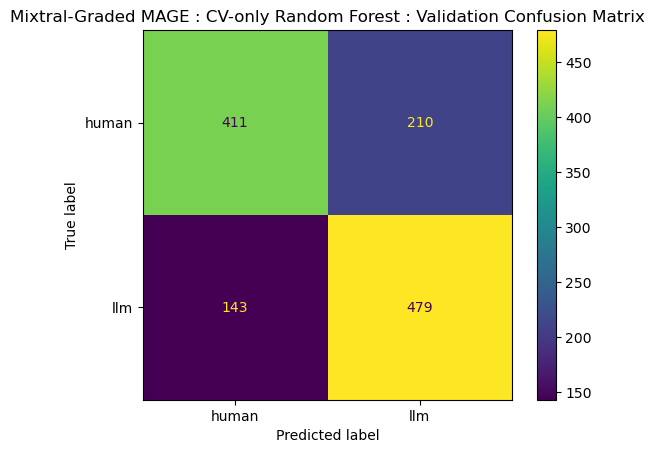

cv_local_p5_w64       0.085846
cv_local_p5_w128      0.084284
cv_local_mean_w128    0.076390
cv_local_p5_w16       0.076015
cv_local_mean_w16     0.075751
cv_local_p5_w32       0.075187
cv_local_p75_w128     0.059273
cv_local_mean_w32     0.059152
cv_local_p25_w128     0.057518
cv_local_mean_w64     0.056374
cv_local_p25_w64      0.055420
cv_local_p75_w64      0.052190
cv_local_p25_w16      0.048284
cv_local_p75_w16      0.047268
cv_local_p25_w32      0.046798
cv_local_p75_w32      0.044249
dtype: float64

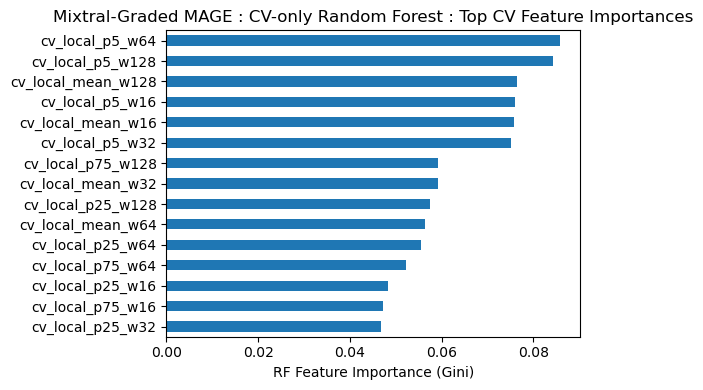

In [72]:
# Run RF on CV features only
cv_rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=cv_features,
    title='Mixtral-Graded MAGE : CV-only Random Forest'
)


## All Features

Now we repeat the same procedure using **All features**.


Mixtral-Graded MAGE : All Features Random Forest
accuracy (val):        0.806
precision_macro (val): 0.808
recall_macro (val):    0.806
f1_macro (val):        0.806
AUROC (val):           0.879


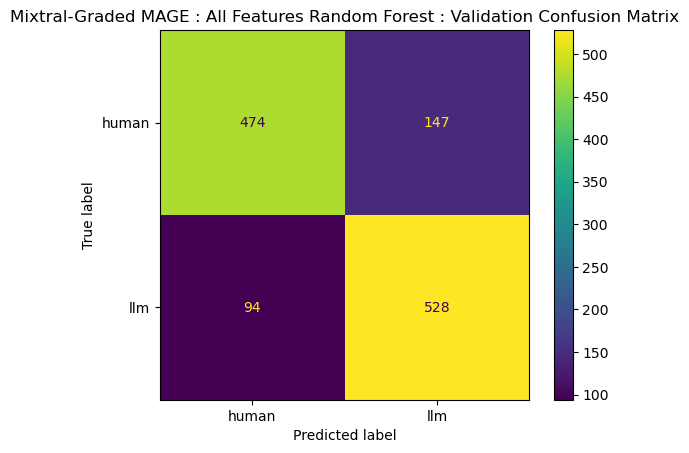

vfd_local_p5_n1       0.052846
vfd_local_p25_n1      0.052809
vfd_local_mean_n1     0.051236
cv_local_p5_w16       0.047422
vfd_local_p75_n1      0.045437
cv_local_p5_w128      0.044474
cv_local_p5_w64       0.044156
cv_local_p5_w32       0.040914
vfd_local_p75_n2      0.032328
vfd_local_p25_n2      0.032318
vfd_local_mean_n2     0.031681
cv_local_p25_w128     0.031600
vfd_local_p5_n2       0.029010
cv_local_p25_w64      0.028944
cv_local_p75_w128     0.026947
cv_local_p75_w64      0.025565
acf_abs_sum_L64       0.025099
acf_lag4              0.024750
cv_local_p25_w32      0.023566
scr_local_mean_w16    0.022878
dtype: float64

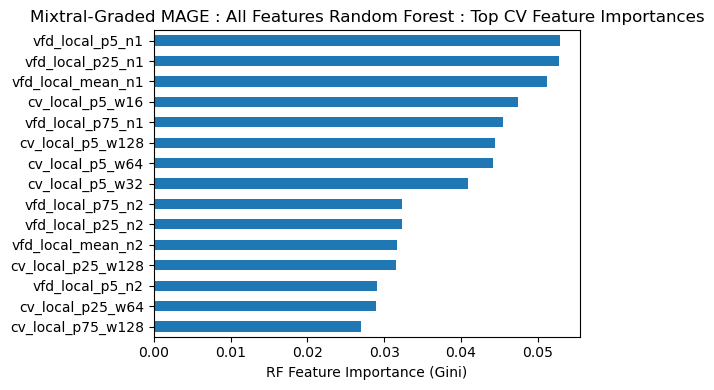

In [73]:
# Run RF on ACF features only
all_features = cv_features + acf_features + vfd_features + scr_features
cv_rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=all_features,
    title='Mixtral-Graded MAGE : All Features Random Forest'
)

## RESULTS (MAGE, Mixtral-Graded)
0.806 F1 score.  Again, variation of diffs is most important.